In [1]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from torch import nn


from torch.utils.data.dataset import random_split

from torch import optim

import torch.nn.functional as F


import numpy as np
import glob
import os
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, auc, accuracy_score
from sklearn.decomposition import PCA

import datetime

%matplotlib inline
warnings.filterwarnings("ignore")
plt.rcParams['xtick.labelsize'] = 10

In [2]:
train_path = "Classification_data/train/"
test_path = "Classification_data/test/"

#to compare algorithms I prepare separate folder with images from the test set
holdout_path = 'Classification_data/holdout/'

In [3]:
class2ind = {}
ind2class = {}

In [4]:
#prepare index to class dictionary
for i, folder in enumerate(os.listdir(train_path)):
   ind2class[i]=folder

In [5]:
#prepare class to index dictionary
class2ind={ind2class[i]: i  for i in range(len(ind2class))}

In [6]:
class2ind

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

I will resize images to 20% of original width and height, to make the feature space smaller.

In [7]:
def get_data(path):
    data = []
    labels = []
    for folder in glob.glob(path + '/*'):
        for filename in glob.glob(folder + "/*.jpg"):
        # print(filename)
            image = cv2.imread(filename)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            #resize image to 20% of its size to make it smaller (30x30X3)
            width = int(image.shape[1] * 0.2)
            height = int(image.shape[0] * 0.2)
            dim = (width, height)
            # resize image
            resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

            # #fill missing values in the image
            # mask = np.zeros(resized.shape, dtype="uint8")
            # mask[np.isnan(resized)] = 255
            # inpainted = cv2.inpaint(resized, mask, 3, cv2.INPAINT_TELEA)

            data.append(resized)
            label = filename.split('\\')[-2]
            labels.append(class2ind[label])

    return data, labels


### Make holdout dataset

To make holdout dataset I will take 10 random images from each folder from the test data and save them into the holdout directory to use further for comparisson of algorithms. So in general I will have holdout test set of 60 images.

In [32]:
#use this function only once to prepare holdout set
def make_holdout(path):
    save_path = "Classification_data/holdout/"
    for folder in glob.glob(path + '/*'):
        files = []
        #make folder in the holdout directory
        folder_name=folder.split("\\")[-1]
        os.mkdir(os.path.join(save_path, folder_name))

        for filename in glob.glob(folder + "/*.jpg"):
            files.append(filename)
        #choose random 10 files
        indexes = np.random.randint(low=0, high=len(files), size=10)
        for idx in indexes:
            image_name = files[idx]
            img = cv2.imread(image_name)
            save_name =save_path+folder_name+"/"+image_name.split("\\")[-1]
            cv2.imwrite(save_name, img)

In [ ]:
make_holdout(test_path)

In [8]:
train_data, train_labels = get_data(train_path)
test_data, test_labels = get_data(test_path)
holdout_data, holdout_labels = get_data(holdout_path)

In [9]:
def visualise_images(data, labels):
    #show 10 random images from data
    fig, axs = plt.subplots(2, 5, figsize=(20, 10))
    idx = np.random.randint(0, len(data), 10)
    for i, index in enumerate(idx):
        axs[i//5, i%5].imshow(data[index], cmap="gray")
        axs[i//5, i%5].axis("off")
        title = ind2class[labels[index]]
        axs[i//5, i%5].set_title(f"Class {title}")
        axs[i//5, i%5].axis("off")

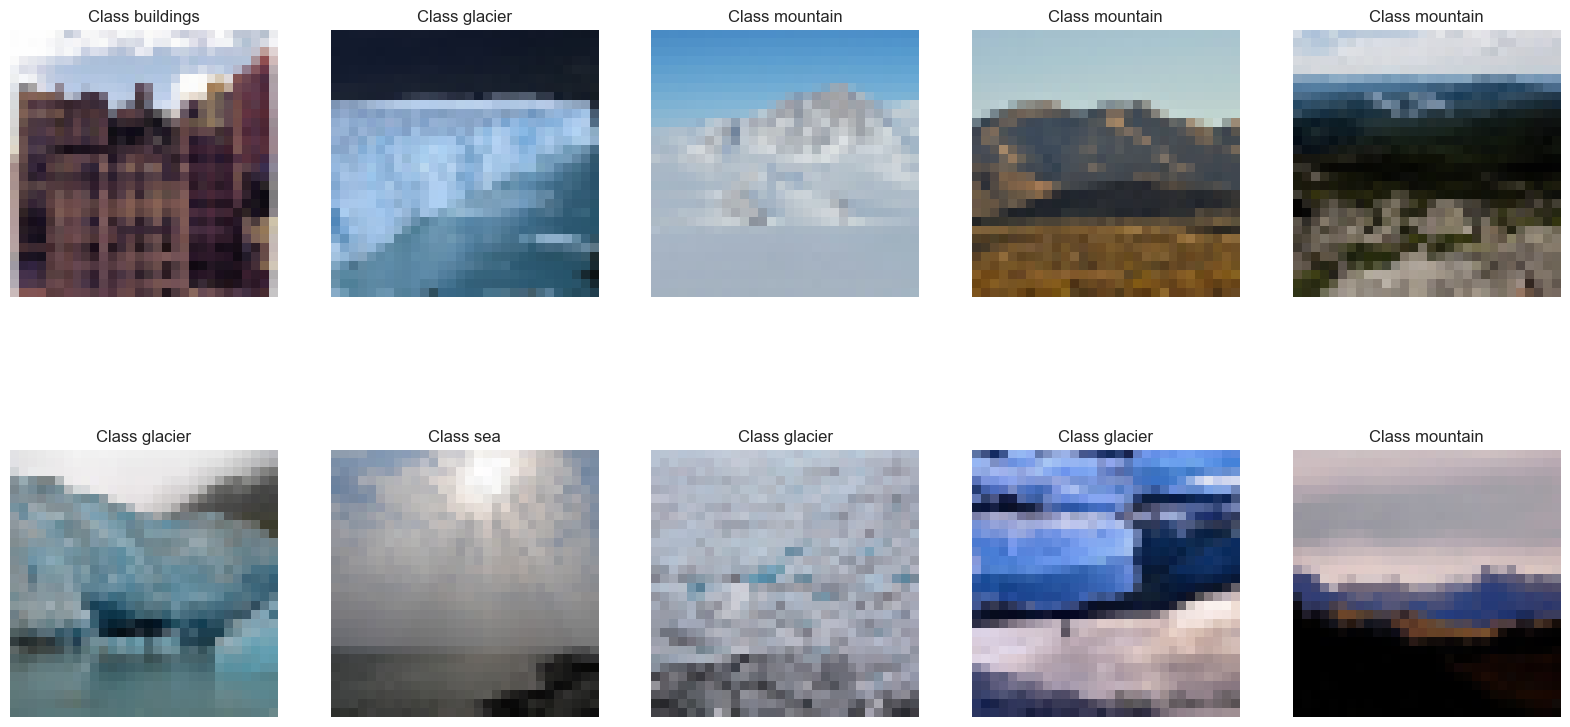

In [10]:
visualise_images(train_data, train_labels)

# Classical approach

I will use image as a long feature vector 75X75X3, reshaping it into the row.

### Prepare train set

In [11]:
train_df = list(map(lambda x: x.flatten(), train_data))

In [12]:
train_df = pd.DataFrame(train_df)

In [13]:
train_df = train_df.astype("float")
train_df = train_df.fillna(0)

In [14]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14034 entries, 0 to 14033
Columns: 2700 entries, 0 to 2699
dtypes: float64(2700)
memory usage: 289.1 MB


In [15]:
train_df.isna().sum().sum()

0

### Prepare test set

In [16]:
test_df = list(map(lambda x: x.flatten(), test_data))

In [17]:
test_df = pd.DataFrame(test_df)

In [18]:
test_df=test_df.astype("float")
test_df=test_df.fillna(0)

### Prepare holdout set

In [19]:
holdout_df = list(map(lambda x: x.flatten(), holdout_data))

In [20]:
holdout_df = pd.DataFrame(holdout_df)
holdout_df = holdout_df.astype("float")
holdout_df = holdout_df.fillna(0)

## Logistic regression

### Base model

In [21]:
#base model
lr = LogisticRegression(random_state=42)

In [22]:
lr.fit(train_df, train_labels)

LogisticRegression(random_state=42)

In [23]:
y_pred = lr.predict(test_df)
y_probs = lr.predict_proba(test_df)

In [24]:
print(f"Accuracy: {accuracy_score(test_labels, y_pred): .4f}")

Accuracy:  0.5380


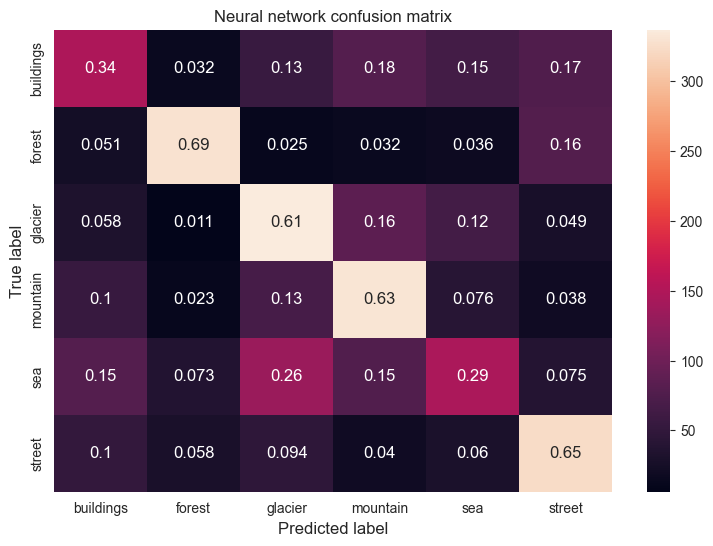

In [25]:
conf = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys(),
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

In [26]:
print(classification_report(test_labels, y_pred, target_names=class2ind.keys()))

              precision    recall  f1-score   support

   buildings       0.38      0.34      0.36       437
      forest       0.77      0.69      0.73       474
     glacier       0.52      0.61      0.56       553
    mountain       0.55      0.63      0.58       525
         sea       0.40      0.29      0.33       510
      street       0.58      0.65      0.61       501

    accuracy                           0.54      3000
   macro avg       0.53      0.53      0.53      3000
weighted avg       0.53      0.54      0.53      3000



### Try PSA

In [27]:
pca = PCA(n_components=0.95)

In [28]:
train_df_pca = pca.fit_transform(train_df)
test_df_pca = pca.transform(test_df)

In [29]:
train_df_pca.shape

(14034, 267)

In [30]:
lr.fit(train_df_pca, train_labels)

LogisticRegression(random_state=42)

In [31]:
y_pred = lr.predict(test_df_pca)
y_probs = lr.predict_proba(test_df_pca)

In [32]:
print(f"Accuracy: {accuracy_score(test_labels, y_pred): .4f}")

Accuracy:  0.5320


After pca accurace got lower. I will leave previous features.

### Huperparameters tunning

with the whole train dataset

In [34]:
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [35]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params = {'penalty': ['l2', 'l1', 'elasticnet', None],
          'C': [0.1, 1, 10, 100]}


grid = GridSearchCV(estimator=lr, param_grid=params, cv=cv, scoring='accuracy', verbose=2)

grid.fit(train_df, train_labels)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ..................................C=0.1, penalty=l2; total time=   8.1s
[CV] END ..................................C=0.1, penalty=l2; total time=   8.2s
[CV] END ..................................C=0.1, penalty=l2; total time=   8.1s
[CV] END ..................................C=0.1, penalty=l2; total time=   7.7s
[CV] END ..................................C=0.1, penalty=l2; total time=   7.6s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..................................C=0.1, penalty=l1; total time=   0.0s
[CV] END ..........................C=0.1, penalty=elasticnet; total time=   0.0s
[CV] END ..........................C=0.1, penalt

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.1, 1, 10, 100],
                         'penalty': ['l2', 'l1', 'elasticnet', None]},
             scoring='accuracy', verbose=2)

In [36]:
grid.best_params_

{'C': 0.1, 'penalty': None}

In [37]:
lr = grid.best_estimator_
lr.fit(train_df, train_labels)

LogisticRegression(C=0.1, penalty=None, random_state=42)

In [38]:
y_pred = lr.predict(test_df)
y_probs = lr.predict_proba(test_df)

In [39]:
print(f"Accuracy: {accuracy_score(test_labels, y_pred): .4f}")

Accuracy:  0.5347


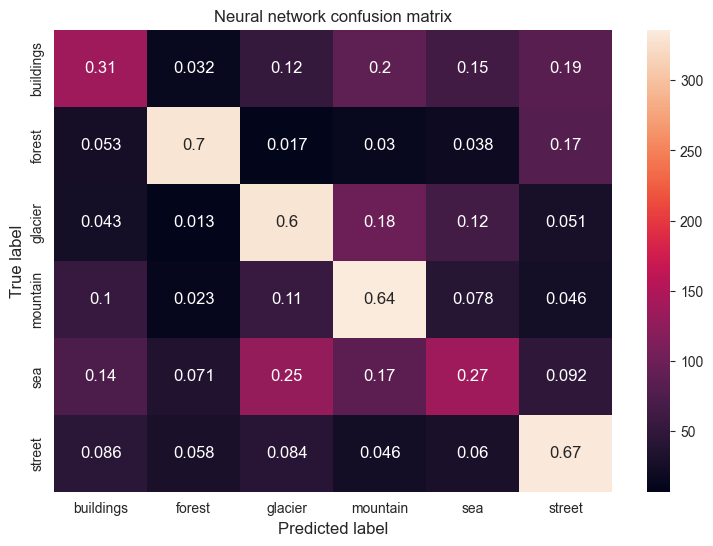

In [40]:
conf = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys(),
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

We can see that buildings and sea are the most difficult to predict

In [41]:
print(classification_report(test_labels, y_pred, target_names=class2ind.keys()))

              precision    recall  f1-score   support

   buildings       0.38      0.31      0.34       437
      forest       0.77      0.70      0.73       474
     glacier       0.53      0.60      0.56       553
    mountain       0.52      0.64      0.57       525
         sea       0.39      0.27      0.32       510
      street       0.56      0.67      0.61       501

    accuracy                           0.53      3000
   macro avg       0.53      0.53      0.52      3000
weighted avg       0.53      0.53      0.53      3000



### Check on holdout set

In [42]:
y_pred = lr.predict(holdout_df)
y_probs = lr.predict_proba(holdout_df)

In [43]:
print(f"Accuracy: {accuracy_score(holdout_labels, y_pred): .4f}")

Accuracy:  0.5424


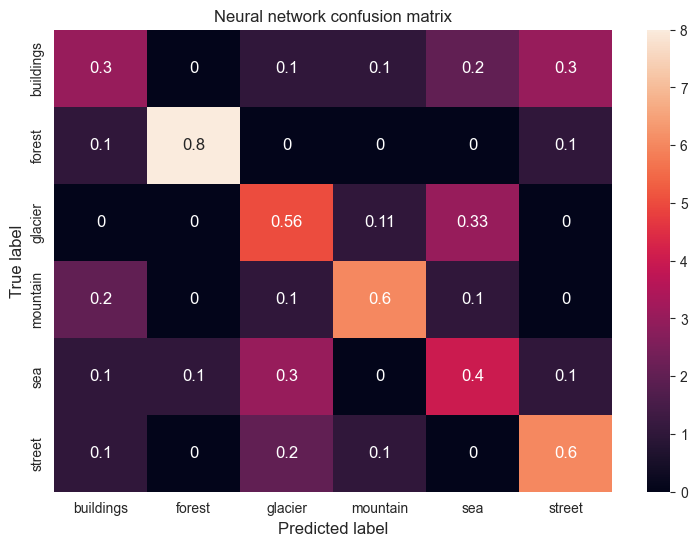

In [44]:
conf = confusion_matrix(holdout_labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys(),
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

In [45]:
print(classification_report(holdout_labels, y_pred, target_names=class2ind.keys()))

              precision    recall  f1-score   support

   buildings       0.38      0.30      0.33        10
      forest       0.89      0.80      0.84        10
     glacier       0.42      0.56      0.48         9
    mountain       0.67      0.60      0.63        10
         sea       0.40      0.40      0.40        10
      street       0.55      0.60      0.57        10

    accuracy                           0.54        59
   macro avg       0.55      0.54      0.54        59
weighted avg       0.55      0.54      0.54        59



In [46]:
scores = {}
scores['LinearRegression']=accuracy_score(holdout_labels, y_pred)

In [47]:
def get_accuracies(y_test, y_pred, class2ind):
    '''
    compute accuracies for each class separately
    y_test - true labels
    y_pred - predicted labels
    class2ind - dictionary of the classes
    return: dictionary of accuracies of each class
    '''
    accuracies={}
    for cl, i in class2ind.items():
        #prepare vector with 1 at the places of given class and 0 at other places
        y_true = np.array([1 if y == i else 0 for y in y_test])
        prediction = np.array([1 if y == i else 0 for y in y_pred])
        accuracies[cl]=accuracy_score(y_true, prediction)

    return accuracies

In [48]:
accuracies = get_accuracies(holdout_labels, y_pred, class2ind)
accuracies_df = pd.Series(accuracies)

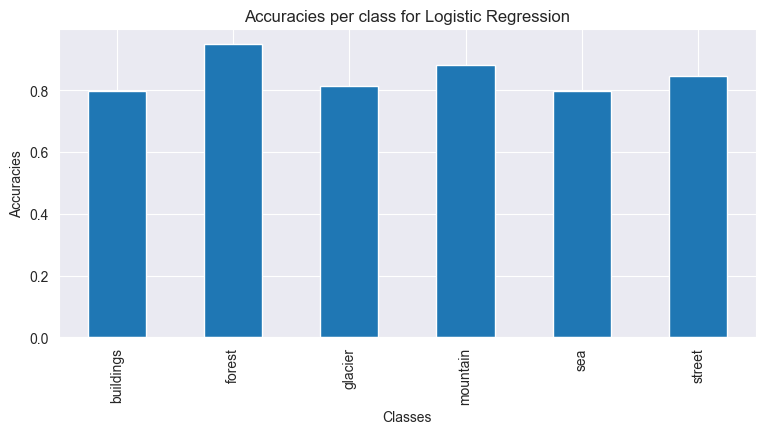

In [49]:
plt.figure(figsize=(9,4))
accuracies_df.plot(kind='bar')
plt.title("Accuracies per class for Logistic Regression")
plt.xlabel("Classes")
plt.ylabel("Accuracies")
plt.show()

We can see from here that **forest** and **mountain** are the best recognized by Logistic Regression model.

## KNN

### Base model

In [50]:
knn = KNeighborsClassifier(n_neighbors=5)

In [51]:
knn.fit(train_df, train_labels)

KNeighborsClassifier()

In [52]:
y_pred = knn.predict(test_df)
y_probs = knn.predict_proba(test_df)
print(f"Accuracy: {accuracy_score(test_labels, y_pred): .4f}")

Accuracy:  0.4807


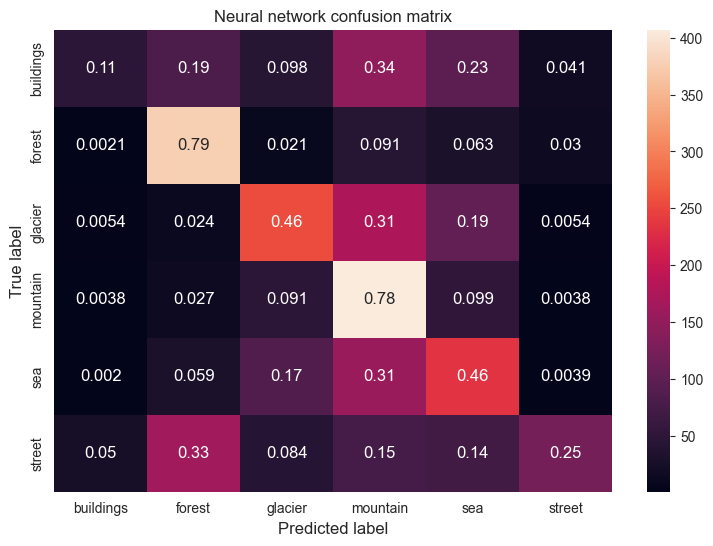

In [53]:
conf = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys(),
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

In [54]:
print(classification_report(test_labels, y_pred, target_names=class2ind.keys()))

              precision    recall  f1-score   support

   buildings       0.59      0.11      0.18       437
      forest       0.55      0.79      0.65       474
     glacier       0.53      0.46      0.49       553
    mountain       0.40      0.78      0.53       525
         sea       0.39      0.46      0.42       510
      street       0.76      0.25      0.37       501

    accuracy                           0.48      3000
   macro avg       0.54      0.47      0.44      3000
weighted avg       0.54      0.48      0.45      3000



### Hyperparameters tunning

In [55]:
knn = KNeighborsClassifier()

In [56]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params = {
        'n_neighbors': [3, 5, 7, 9, 11],
         'metric': ['euclidian', 'cosine', 'cityblock']
}

grid = GridSearchCV(estimator=knn, param_grid=params, cv=cv, scoring='accuracy', verbose=2)

grid.fit(train_df, train_labels)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] END ....................metric=euclidian, n_neighbors=3; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=3; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=3; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=3; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=3; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=5; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=5; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=5; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=5; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=5; total time=   0.0s
[CV] END ....................metric=euclidian, n_neighbors=7; total time=   0.0s
[CV] END ....................metric=euclidian, n

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidian', 'cosine', 'cityblock'],
                         'n_neighbors': [3, 5, 7, 9, 11]},
             scoring='accuracy', verbose=2)

In [57]:
grid.best_params_

{'metric': 'cityblock', 'n_neighbors': 9}

In [58]:
knn = grid.best_estimator_
knn.fit(train_df, train_labels)

KNeighborsClassifier(metric='cityblock', n_neighbors=9)

In [59]:
y_pred = knn.predict(test_df)
y_probs = knn.predict_proba(test_df)

In [60]:
print(f"Accuracy: {accuracy_score(test_labels, y_pred): .4f}")

Accuracy:  0.5060


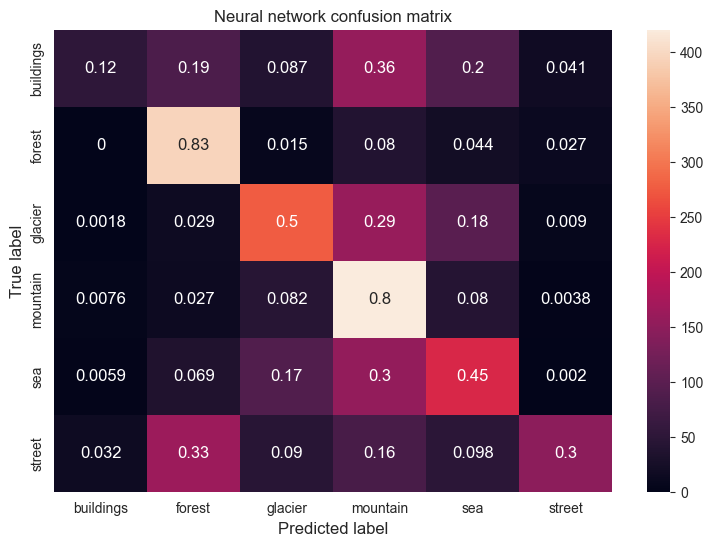

In [61]:
conf = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys(),
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

In [62]:
print(classification_report(test_labels, y_pred, target_names=class2ind.keys()))

              precision    recall  f1-score   support

   buildings       0.68      0.12      0.20       437
      forest       0.56      0.83      0.67       474
     glacier       0.55      0.50      0.53       553
    mountain       0.42      0.80      0.55       525
         sea       0.43      0.45      0.44       510
      street       0.79      0.30      0.43       501

    accuracy                           0.51      3000
   macro avg       0.57      0.50      0.47      3000
weighted avg       0.57      0.51      0.47      3000



### Check on holdout set

In [63]:
y_pred = lr.predict(holdout_df)
y_probs = lr.predict_proba(holdout_df)
print(f"Accuracy: {accuracy_score(holdout_labels, y_pred): .4f}")

Accuracy:  0.5424


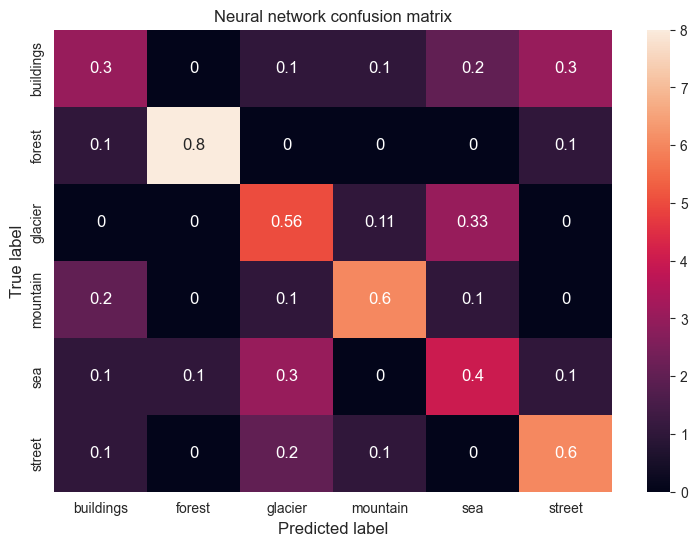

In [64]:
conf = confusion_matrix(holdout_labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys(),
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

In [65]:
print(classification_report(holdout_labels, y_pred, target_names=class2ind.keys()))

              precision    recall  f1-score   support

   buildings       0.38      0.30      0.33        10
      forest       0.89      0.80      0.84        10
     glacier       0.42      0.56      0.48         9
    mountain       0.67      0.60      0.63        10
         sea       0.40      0.40      0.40        10
      street       0.55      0.60      0.57        10

    accuracy                           0.54        59
   macro avg       0.55      0.54      0.54        59
weighted avg       0.55      0.54      0.54        59



In [66]:
scores['Knn']=accuracy_score(holdout_labels, y_pred)

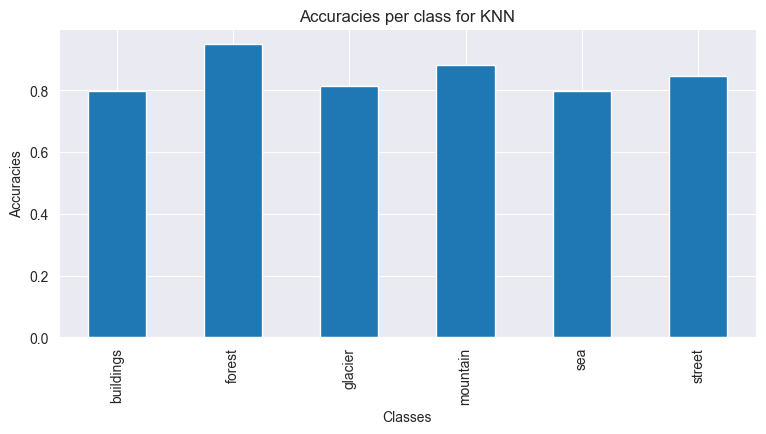

In [67]:
accuracies = get_accuracies(holdout_labels, y_pred, class2ind)
accuracies_df = pd.Series(accuracies)
plt.figure(figsize=(9, 4))
accuracies_df.plot(kind='bar')
plt.title("Accuracies per class for KNN")
plt.xlabel("Classes")
plt.ylabel("Accuracies")
plt.show()

The same: **forest** and **mountain** got predicted with the highest accuracy.

## SVM

### Base model

In [71]:
svc = SVC(kernel='rbf', random_state=42, probability=True)

In [72]:
svc.fit(train_df, train_labels)

SVC(probability=True, random_state=42)

In [73]:
y_pred = svc.predict(test_df)
y_probs = svc.predict_proba(test_df)
print(f"Accuracy: {accuracy_score(test_labels, y_pred): .4f}")

Accuracy:  0.6470


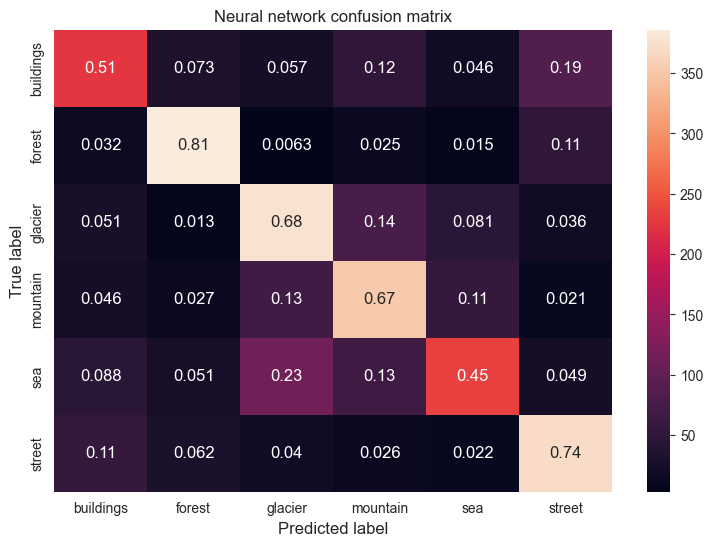

In [74]:
conf = confusion_matrix(test_labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys(),
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

Here **sea** and **buildings** got the lowest score for prediction.

In [75]:
print(classification_report(test_labels, y_pred, target_names=class2ind.keys()))

              precision    recall  f1-score   support

   buildings       0.57      0.51      0.54       437
      forest       0.78      0.81      0.80       474
     glacier       0.62      0.68      0.65       553
    mountain       0.62      0.67      0.64       525
         sea       0.63      0.45      0.53       510
      street       0.66      0.74      0.70       501

    accuracy                           0.65      3000
   macro avg       0.65      0.65      0.64      3000
weighted avg       0.64      0.65      0.64      3000



### Hyperparameters tunning

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

params = {
        'C': [1, 10, 100],
         'gamma': [0.01, 1, 100]
}

grid = GridSearchCV(estimator=svc, param_grid=params, cv=cv, scoring='accuracy', verbose=2)

grid.fit(train_df, train_labels)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ....................................C=1, gamma=0.01; total time=27.5min
[CV] END ....................................C=1, gamma=0.01; total time=26.9min


For classical features I will use histograms as bag of visual words.
I will create normalized histogram of the whole image, and of its parts:
* dividing the image into 9 subblocks: 50X50 pixels each
* dividing the image into 3 horizontal blocks: 50X150 pixels each
* dividing the image into 3 vertical blocks: 150X50 pixels each
and computing histograms of all of them.

I will use 16 bins. And as it will be done for 3 channels, I will get 3*(3+3+9)*16=720 features.

In [211]:
def calc_hist(img):
    '''
    Simple histogram of 16 bins for each channels
    :return: concatenated histogram of three channels, array of shape (48,1)
    '''
    r_hist = cv2.calcHist(img, [0], None, [16], [0, 256])
    g_hist = cv2.calcHist(img, [1], None, [16], [0, 256])
    b_hist = cv2.calcHist(img, [2], None, [16], [0, 256])


    #normalize histograms
    cv2.normalize(r_hist, r_hist, 0, 1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(g_hist, g_hist, 0, 1, norm_type=cv2.NORM_MINMAX)
    cv2.normalize(b_hist, b_hist, 0, 1, norm_type=cv2.NORM_MINMAX)

    #calculate histograms of 9 subblocks of 50X50 length
    # r_subblocks=[]
    # g_subblocks=[]
    # b_subblocks=[]
    # for i in range(3):
    #     for j in range(3):
    #         r_subblocks.append(cv2.calcHist(img[i*50:(i+1)*50, j*50:(j+1)*50], [0], None, [16], [0, 256]))
    #         g_subblocks.append(cv2.calcHist(img[i*50:(i+1)*50, j*50:(j+1)*50], [1], None, [16], [0, 256]))
    #         b_subblocks.append(cv2.calcHist(img[i*50:(i+1)*50, j*50:(j+1)*50], [2], None, [16], [0, 256]))
    #
    # print(len(r_subblocks))
    # print(r_subblocks)
    # #calculate histograms of horizontal blocks (50X150)
    # r_hor = []
    # g_hor = []
    # b_hor = []
    # for i in range(3):
    #     r_hor.append(cv2.calcHist(img[i*50:(i+1)*50, :], [0], None, [16], [0, 256]))
    #     g_hor.append(cv2.calcHist(img[i*50:(i+1)*50,:], [1], None, [16], [0, 256]))
    #     b_hor.append(cv2.calcHist(img[i*50:(i+1)*50, :], [2], None, [16], [0, 256]))
    #
    # #calculate histograms of vertical blocks (50X150)
    # r_vert = []
    # g_vert = []
    # b_vert = []
    # for i in range(3):
    #     r_vert.append(cv2.calcHist(img[:, i*50:(i+1)*50], [0], None, [16], [0, 256]))
    #     g_vert.append(cv2.calcHist(img[:, i*50:(i+1)*50], [1], None, [16], [0, 256]))
    #     b_vert.append(cv2.calcHist(img[:, i*50:(i+1)*50], [2], None, [16], [0, 256]))

    result = np.array(np.vstack([r_hist, g_hist, b_hist])).flatten()


    return result

    # return np.vstack([np.array(r_hist).flatten(),
    #                   np.array(g_hist).flatten(),
    #                   np.array(b_hist).flatten(),
    #                   np.array(r_subblocks).flatten(),
    #                   np.array(g_subblocks).flatten(),
    #                   np.array(b_subblocks).flatten(),
    #                   np.array(r_hor).flatten(),
    #                   np.array(g_hor).flatten(),
    #                   np.array(b_hor).flatten(),
    #                   np.array(r_vert).flatten(),
    #                   np.array(g_vert).flatten(),
    #                   np.array(b_vert).flatten()])

In [212]:
rgb_hist = calc_hist(train_data[1])

In [213]:
print(rgb_hist)

[0.         0.         0.         0.         0.4473684  0.2236842
 0.36842105 0.67105263 0.7236842  0.43421054 0.32894737 1.
 0.7236842  0.36842105 0.6184211  0.01315789 0.         0.
 0.         0.         0.42857143 0.20238096 0.3809524  0.6547619
 0.5595238  0.3452381  0.2857143  1.         0.5833334  0.29761904
 0.47619048 0.14285715 0.         0.         0.         0.
 0.5285714  0.17142858 0.42857143 0.85714287 0.6142857  0.51428574
 0.31428573 0.94285715 1.         0.2857143  0.31428573 0.45714286]


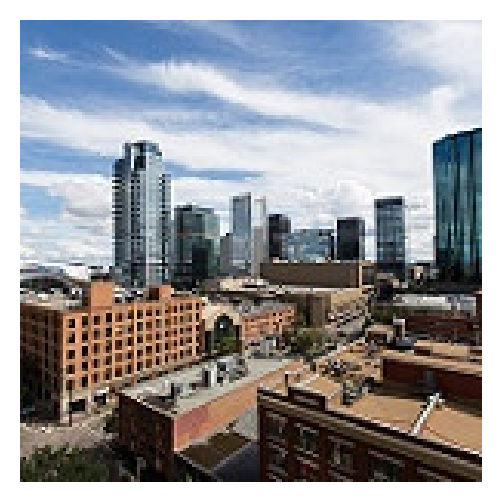

In [214]:
plt.figure(figsize=(5,3))
plt.imshow(train_data[1])
plt.axis("off")
plt.show()

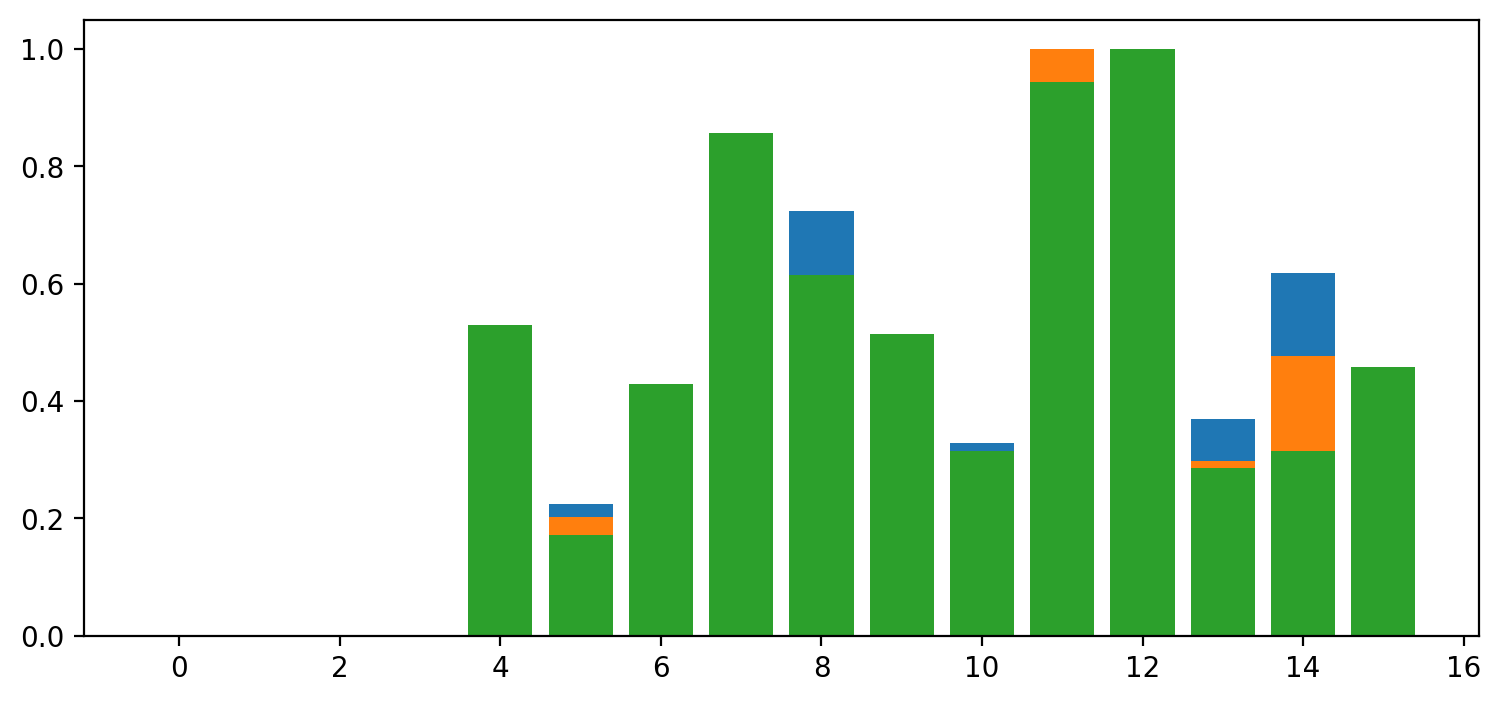

In [215]:
plt.figure(figsize=(9,4))
plt.bar(x=range(16), height = rgb_hist[:16].ravel())
plt.bar(x=range(16), height = rgb_hist[16:32].ravel())
plt.bar(x=range(16), height = rgb_hist[32:48].ravel())
plt.show()

In [216]:
train_hist = []
for image in train_data:
    train_hist.append(calc_hist(image))

In [217]:
test_hist = []
for image in test_data:
    test_hist.append(calc_hist(image))

In [218]:
X_train = pd.DataFrame(train_hist)
X_test = pd.DataFrame(test_hist)
y_train = pd.Series(train_labels)
y_test = pd.Series(test_labels)

In [219]:
X_train

0             1         2         3         4         5   \
0      0.000000  0.000000e+00  0.000000  0.000000  0.000000  0.000000   
1      0.000000  0.000000e+00  0.000000  0.000000  0.447368  0.223684   
2      0.000000  0.000000e+00  0.000000  0.010309  0.000000  0.020619   
3      0.775862  1.000000e+00  0.379310  0.224138  0.206897  0.224138   
4      0.881890  2.992126e-01  0.244094  1.000000  0.181102  0.811024   
...         ...           ...       ...       ...       ...       ...   
14029  0.420290  1.014493e-01  0.072464  0.202899  0.144928  0.115942   
14030  0.185897  1.000000e+00  0.384615  0.179487  0.217949  0.275641   
14031  0.279412  4.411765e-01  0.110294  0.110294  0.117647  0.110294   
14032  1.000000  9.470199e-01  0.039735  0.000000  0.006623  0.112583   
14033  0.216216 -7.450581e-09  0.135135  0.270270  0.351351  0.837838   

             6         7             8         9   ...        38        39  \
0      0.000000  0.000000  0.000000e+00  0.000000  ...  0.000000  0.000000   
1      0.368421  0.671053  7.236842e-01  0.434211  ...  0.428571  0.857143   
2      0.010309  0.072165  6.701031e-01  0.515464  ...  0.032609  0.097826   
3      0.396552  0.586207  4.827586e-01  0.586207  ...  0.543860  0.631579   
4      0.125984  0.000000  0.000000e+00  0.000000  ...  0.153846  0.000000   
...         ...       ...           ...       ...  ...       ...       ...   
14029  0.057971  0.000000  1.449275e-02  0.000000  ...  0.095238  0.023810   
14030  0.121795  0.025641 -4.656613e-10  0.019231  ...  0.191489  0.085106   
14031  0.088235  0.110294  8.088236e-02  0.066176  ...  0.156250  0.148438   
14032  0.827815  0.046358  0.000000e+00  0.000000  ...  0.000000  0.000000   
14033  1.000000  0.621622  9.189189e-01  0.783784  ...  1.000000  0.756757   

             40        41            42        43        44        45  \
0      0.000000  0.000000  0.000000e+00  0.000000  0.000000  0.000000   
1      0.614286  0.514286  3.142857e-01  0.942857  1.000000  0.285714   
2      0.728261  0.608696  1.847826e-01  0.184783  0.847826  0.619565   
3      0.526316  0.491228  2.456140e-01  0.719298  1.000000  0.631579   
4      0.000000  0.000000  0.000000e+00  0.000000  0.000000  0.000000   
...         ...       ...           ...       ...       ...       ...   
14029  0.047619  0.023810 -9.313226e-10  0.047619  0.047619  0.119048   
14030  0.035461  0.042553  3.546099e-02  0.042553  0.063830  0.028369   
14031  0.125000  0.085938  7.031250e-02  0.125000  0.023438  0.000000   
14032  0.000000  0.161538  6.230769e-01  0.369231  0.000000  0.000000   
14033  0.567568  0.243243  4.324324e-01  0.324324  0.162162  0.162162   

             46        47  
0      0.000000  1.000000  
1      0.314286  0.457143  
2      1.000000  0.467391  
3      0.070175  0.000000  
4      0.000000  0.000000  
...         ...       ...  
14029  0.071429  1.000000  
14030  0.049645  0.000000  
14031  0.093750  1.000000  
14032  0.000000  0.000000  
14033  0.648649  0.513514  

[14034 rows x 48 columns]

In [220]:
X_test

0         1         2         3         4         5         6   \
0     0.000000  0.000000  0.000000  0.036585  0.048780  0.097561  0.524390   
1     0.017857  0.044643  0.089286  0.151786  0.187500  0.133929  0.946429   
2     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
3     0.010638  0.074468  0.000000  0.074468  0.095745  0.085106  0.085106   
4     0.000000  0.000000  1.000000  0.000000  0.033333  0.966667  0.000000   
...        ...       ...       ...       ...       ...       ...       ...   
2995  0.000000  0.000000  0.024631  0.078818  0.167488  0.157635  0.108374   
2996  0.046931  0.018051  0.018051  0.054152  0.061372  0.104693  0.115523   
2997  1.000000  0.000000  0.000000  0.000000  0.000000  1.000000  0.000000   
2998  0.000000  0.000000  0.000000  0.000000  0.000000  0.012552  0.008368   
2999  0.909722  1.000000  0.666667  0.361111  0.083333  0.020833  0.020833   

            7         8         9   ...        38        39        40  \
0     0.439024  0.634146  0.707317  ...  0.628205  0.384615  0.769231   
1     0.187500  0.062500  0.053571  ...  0.820513  0.188034  0.051282   
2     0.000000  0.000000  0.000000  ...  0.016129  0.000000  0.010753   
3     0.085106  0.159574  0.680851  ...  0.079545  0.125000  0.215909   
4     0.000000  0.106667  0.893333  ...  0.000000  0.000000  0.013333   
...        ...       ...       ...  ...       ...       ...       ...   
2995  0.152709  0.137931  0.147783  ...  0.193548  0.112903  0.188172   
2996  0.079422  0.028881  0.046931  ...  0.072581  0.092742  0.032258   
2997  0.000000  0.000000  0.086667  ...  0.000000  0.000000  0.000000   
2998  0.025105  0.179916  0.104603  ...  0.012712  0.000000  0.148305   
2999  0.041667  0.013889  0.000000  ...  0.020000  0.026667  0.026667   

            41        42        43        44        45        46        47  
0     0.641026  0.217949  0.205128  0.461538  0.269231  1.000000  0.756410  
1     0.094017  0.102564  1.000000  0.076923  0.692308  0.341880  0.000000  
2     0.005376  0.000000  0.000000  0.043011  0.639785  1.000000  0.672043  
3     0.727273  0.704545  1.000000  0.363636  0.079545  0.318182  0.931818  
4     0.986667  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
...        ...       ...       ...       ...       ...       ...       ...  
2995  0.193548  0.086022  0.086022  0.059140  0.016129  0.032258  1.000000  
2996  0.048387  0.032258  0.000000  0.032258  0.016129  0.000000  1.000000  
2997  0.040000  0.593333  0.366667  0.000000  0.000000  0.000000  0.000000  
2998  0.059322  0.262712  1.000000  0.411017  0.000000  0.000000  0.000000  
2999  0.020000  0.006667  0.006667  0.000000  0.000000  0.000000  0.000000  

[3000 rows x 48 columns]

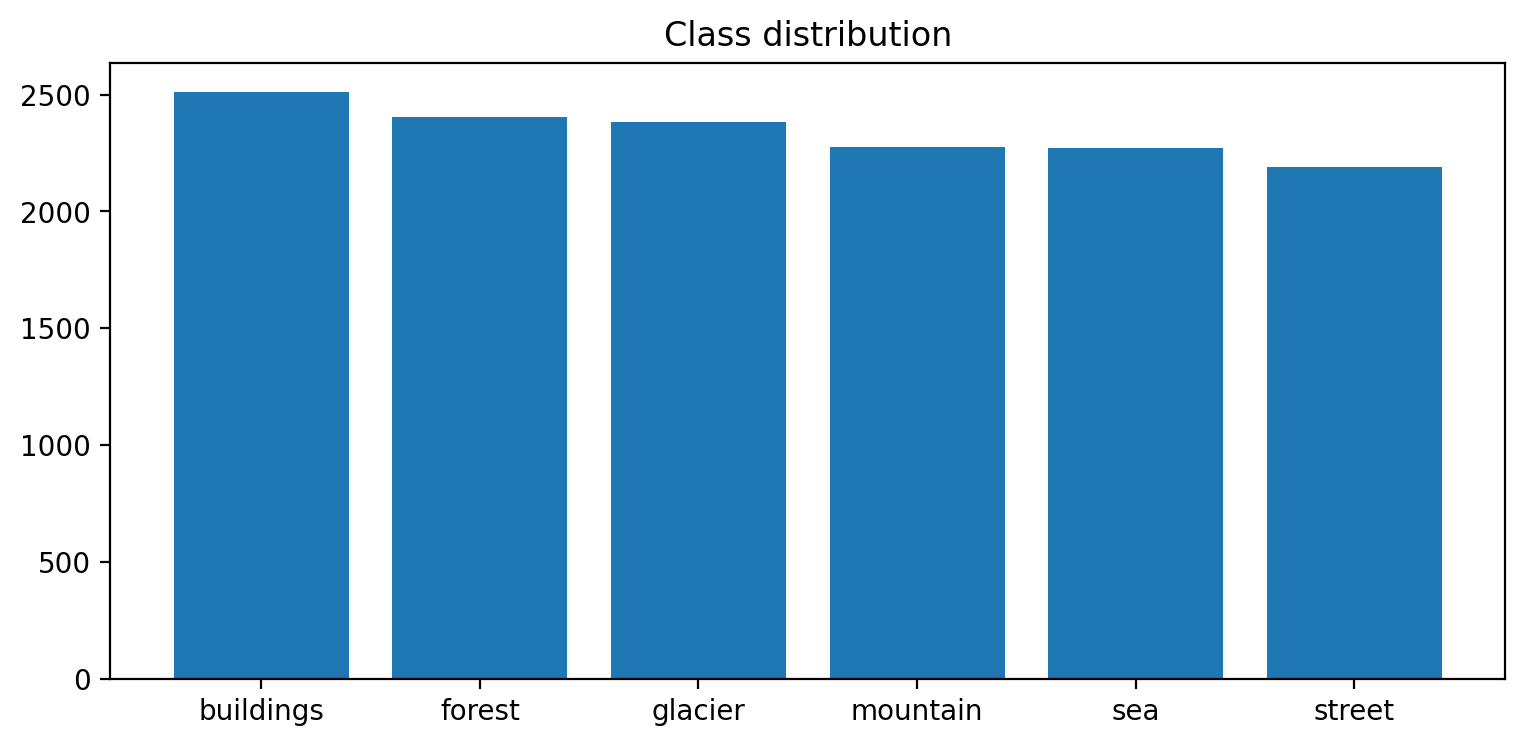

In [221]:
plt.figure(figsize=(9,4))
plt.bar(x=range(1,7), height=y_train.value_counts())
plt.xticks(range(1,7), ind2class.values())
plt.title("Class distribution")
plt.show()

In [222]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 42, stratify=train_labels)

In [223]:
X_train.shape

(11227, 48)

In [224]:
X_val.shape

(2807, 48)

In [225]:
X_test.shape

(3000, 48)

## Logistic regression model

In [206]:
lr = LogisticRegression()

In [207]:
lr.fit(X_train, y_train)

LogisticRegression()

In [208]:
y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)

In [209]:
y_pred

array([3, 3, 3, ..., 4, 3, 1], dtype=int64)

In [210]:
print(f"Accuracy {accuracy_score(y_test, y_pred): .4f}")

Accuracy  0.3097


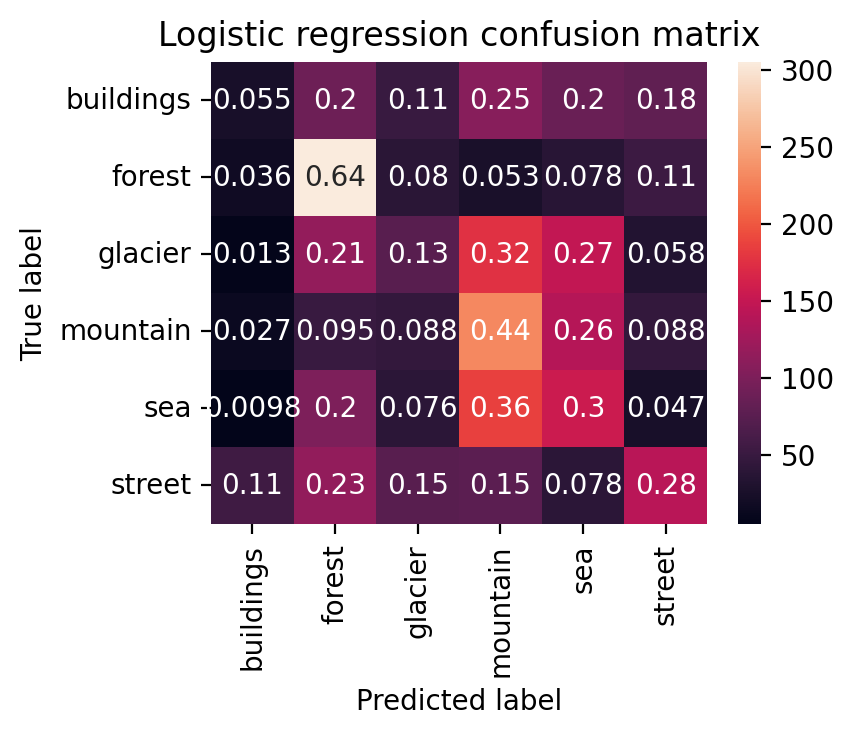

In [227]:
conf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3));
sns.heatmap(conf,
            annot=conf/conf.astype(np.float).sum(axis=1, keepdims=True), #normalized by true class sizes
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys());
plt.title('Logistic regression confusion matrix');
plt.xlabel('Predicted label');
plt.ylabel('True label');

In [228]:
print(classification_report(y_test, y_pred, target_names=class2ind.keys()))

              precision    recall  f1-score   support

   buildings       0.20      0.05      0.09       437
      forest       0.39      0.64      0.49       474
     glacier       0.23      0.13      0.17       553
    mountain       0.29      0.44      0.35       525
         sea       0.26      0.30      0.28       510
      street       0.38      0.28      0.32       501

    accuracy                           0.31      3000
   macro avg       0.29      0.31      0.28      3000
weighted avg       0.29      0.31      0.28      3000



<AxesSubplot: >

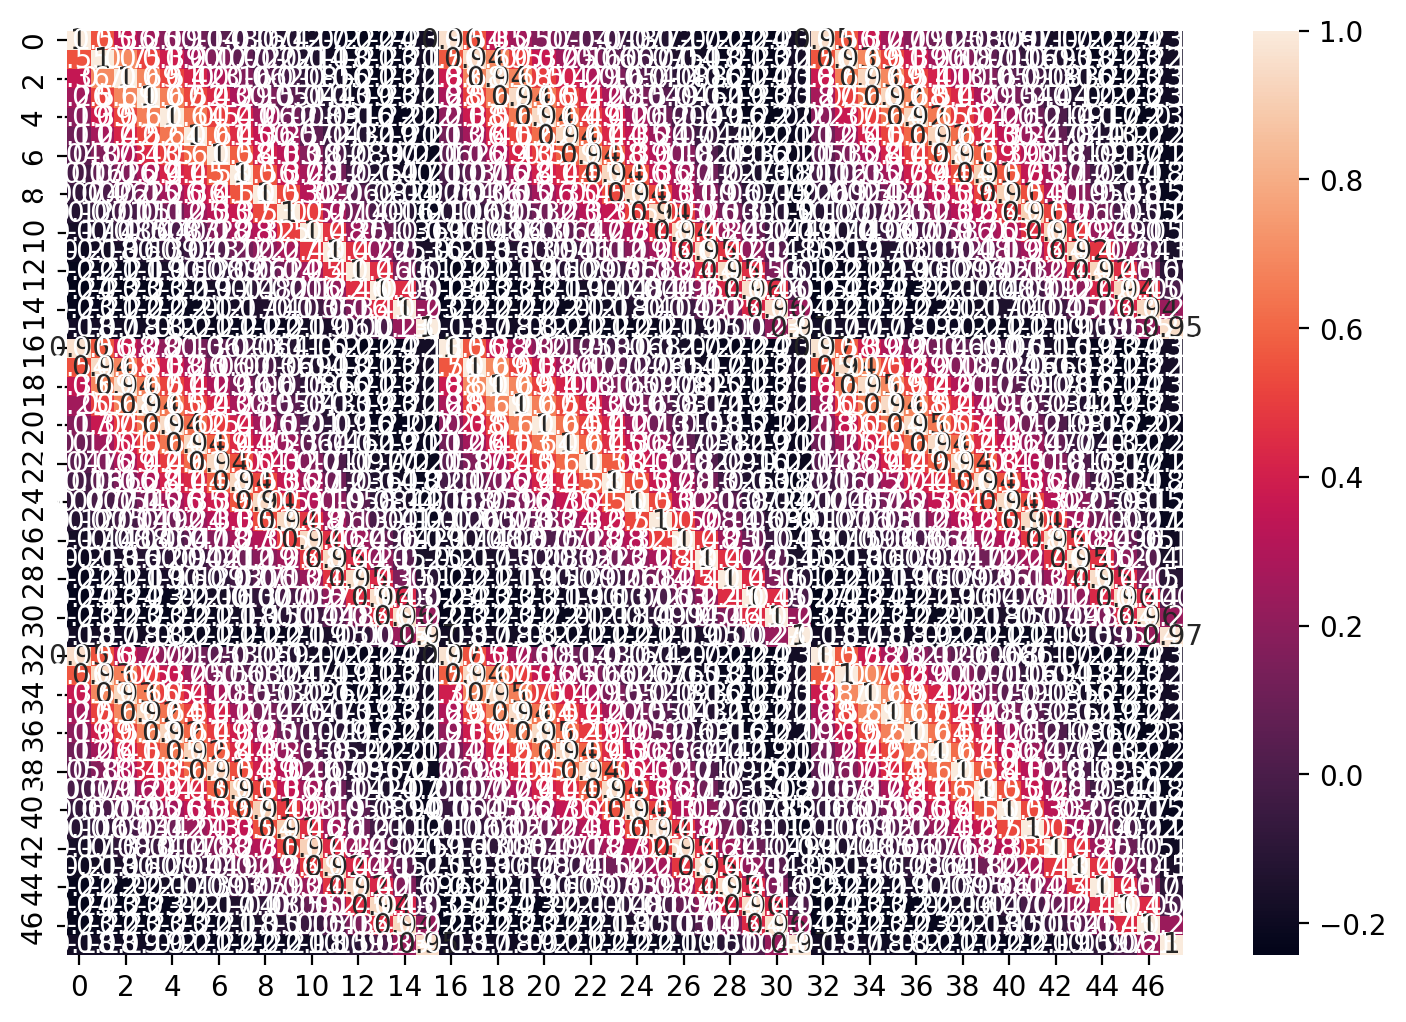

In [230]:
corr = X_train.corr()
sns.heatmap(corr, annot=True)

Features are highly correlated. Let's do PCA.

In [233]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)

In [235]:
X_train_pca.shape

(11227, 15)

In [238]:
X_test_pca = pca.transform(X_test)

### Tuning hyperparameters

In [240]:
lr.fit(X_train_pca, y_train)

LogisticRegression()

In [241]:
y_pred = lr.predict(X_test_pca)
y_prob = lr.predict_proba(X_test_pca)

In [242]:
print(f"Accuracy {accuracy_score(y_test, y_pred): .4f}")

Accuracy  0.3470


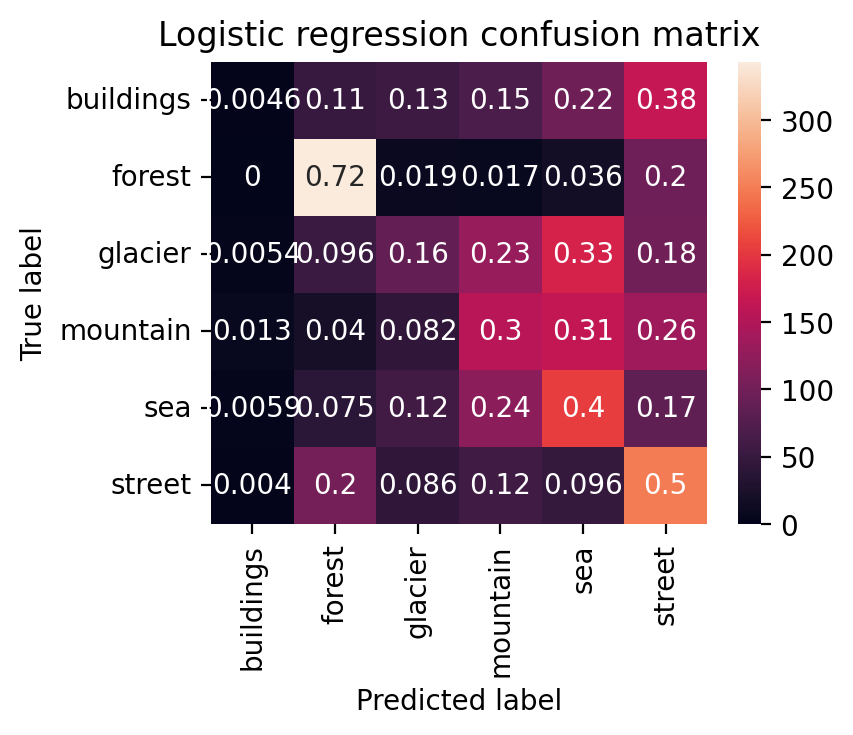

In [243]:
conf = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3));
sns.heatmap(conf,
            annot=conf/conf.astype(np.float).sum(axis=1, keepdims=True), #normalized by true class sizes
            yticklabels=class2ind.keys(),
            xticklabels=class2ind.keys());
plt.title('Logistic regression confusion matrix');
plt.xlabel('Predicted label');
plt.ylabel('True label');

### Using keypoints and descriptors

In [258]:
def get_keypoints(img, maxFeatures):
    # convert input image to grayscale
   imageGray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # use ORB to detect keypoints and extract (binary) local
	# invariant features
   orb = cv2.ORB_create(maxFeatures)
	# extract keypoints and descriptors for image A
   (kps, descs) = orb.detectAndCompute(imageGray, None)
   if (kps is not None) and (descs is not None):
        output_image = cv2.drawKeypoints(img, kps, 0, (0, 0, 255),
                                 flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
        cv2.imshow("Keypoints", output_image)
        cv2.waitKey(0)

   return kps, descs


In [260]:
kps, descs = get_keypoints(train_data[0], 100)

In [262]:
len(descs)

56

# NN approach

### Create dataset of image folders

In [12]:
#make seed for the same randomness
torch.manual_seed(42)

In [13]:
train_path = "Classification_data/train/"
test_path = "Classification_data/test/"

In [14]:
train_transform = transforms.Compose([
    transforms.Resize(size=(150, 150)),
    transforms.RandomRotation((0,40)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop((150, 150), scale=(0.2, 1), ratio=(1, 1)),
    transforms.ToTensor(), #rescale image from (0-255) to (0,1)
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #normalization from ImageNet
])


test_transform = transforms.Compose([
    transforms.Resize(size=(150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# val_transform = transforms.Compose([
#     transforms.Resize(size=(150, 150)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

In [15]:
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
# val_dataset = datasets.ImageFolder(val_path, transform=val_transform)
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)

In [16]:
BATCH_SIZE = 64

In [17]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [18]:
train_dataset.classes

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [19]:
class CNN(torch.nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.convolutional_layers = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1), #output 16x150x150
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=16),
            torch.nn.MaxPool2d(kernel_size=(2,2)),#output 16x75x75

            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=32),
            torch.nn.MaxPool2d(kernel_size=(2,2)), #output 32x37x37

            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.MaxPool2d(kernel_size=(2,2)), #output 64x18x18

            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.BatchNorm2d(num_features=128),
            torch.nn.MaxPool2d(kernel_size=(2,2)), #output 128x9x9


        )

        #fully connected layer
        self.dense_layers = torch.nn.Sequential(
            nn.Flatten(),
            torch.nn.Linear(9*9*128, 512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512, num_classes)
        )
    # fo
    def forward(self, X):
        out = self.convolutional_layers(X)
        out = self.dense_layers(out)
        return out

In [20]:
model = CNN(num_classes=6)

In [45]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# optimization of learning rate by factor 0.9 if there is no improvement for 5 epochs
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.9, patience=5, verbose=True)

In [21]:
def train_CNN(model, loss, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)
  train_accs=np.zeros(epochs)
  test_accs=np.zeros(epochs)



  for epoch in range(epochs):
    model.train()
    t0 = datetime.datetime.now()


    train_loss=[]
    train_correct, train_total = 0.0, 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()

        losses = loss(outputs, targets)
        losses.backward()
        optimizer.step()
        train_loss.append(losses.item())
        train_correct+=(outputs.argmax(axis=1)==targets).sum()
        train_total+=targets.shape[0]


    train_loss = np.mean(train_loss)




    model.eval()
    test_loss=[]
    test_correct, test_total = 0.0, 0.0
    for inputs, targets in test_loader:
        outputs = model(inputs).squeeze()
        losses = loss(outputs, targets)
        test_loss.append(losses.item())
        test_correct+=(outputs.argmax(axis=1)==targets).sum()
        test_total+=targets.shape[0]


    test_loss = np.mean(test_loss)
    #check the learning rate
    scheduler.step(test_loss)

    train_losses[epoch] = train_loss
    test_losses[epoch] = test_loss
    train_accs[epoch]= train_correct/train_total #overall accuracy per epoch
    test_accs[epoch]=test_correct/test_total

    dt = datetime.datetime.now() - t0
    print(f'Epoch {epoch+1}/{epochs}  Train Loss: {train_loss:.4f}  Train Acc: {train_correct/train_total: .4f} Val Loss: {test_loss:.4f} Val Acc: {test_correct/test_total: .4f} Duration: {dt}')

  return train_losses, test_losses, train_accs, test_accs

In [50]:
EPOCHS = 100
train_losses, test_losses, train_accs, test_accs = train_CNN(model, loss, optimizer, train_dataloader, test_dataloader,
                                                           EPOCHS)

Epoch 1/100  Train Loss: 1.3557  Train Acc:  0.5353 Val Loss: 0.7892 Val Acc:  0.7073 Duration: 0:03:01.889245
Epoch 2/100  Train Loss: 0.9891  Train Acc:  0.6345 Val Loss: 0.8405 Val Acc:  0.6890 Duration: 0:03:08.057704
Epoch 3/100  Train Loss: 0.9305  Train Acc:  0.6608 Val Loss: 0.7624 Val Acc:  0.7300 Duration: 0:03:07.440134
Epoch 4/100  Train Loss: 0.8564  Train Acc:  0.6880 Val Loss: 0.7546 Val Acc:  0.7380 Duration: 0:03:11.951672
Epoch 5/100  Train Loss: 0.8290  Train Acc:  0.7008 Val Loss: 0.6768 Val Acc:  0.7667 Duration: 0:03:14.693557
Epoch 6/100  Train Loss: 0.7906  Train Acc:  0.7128 Val Loss: 0.5983 Val Acc:  0.7953 Duration: 0:03:20.762151
Epoch 7/100  Train Loss: 0.7665  Train Acc:  0.7282 Val Loss: 0.6833 Val Acc:  0.7737 Duration: 0:03:15.307212
Epoch 8/100  Train Loss: 0.7404  Train Acc:  0.7403 Val Loss: 0.7307 Val Acc:  0.7490 Duration: 0:03:12.226473
Epoch 9/100  Train Loss: 0.7060  Train Acc:  0.7483 Val Loss: 0.5670 Val Acc:  0.7987 Duration: 0:03:12.345098
E

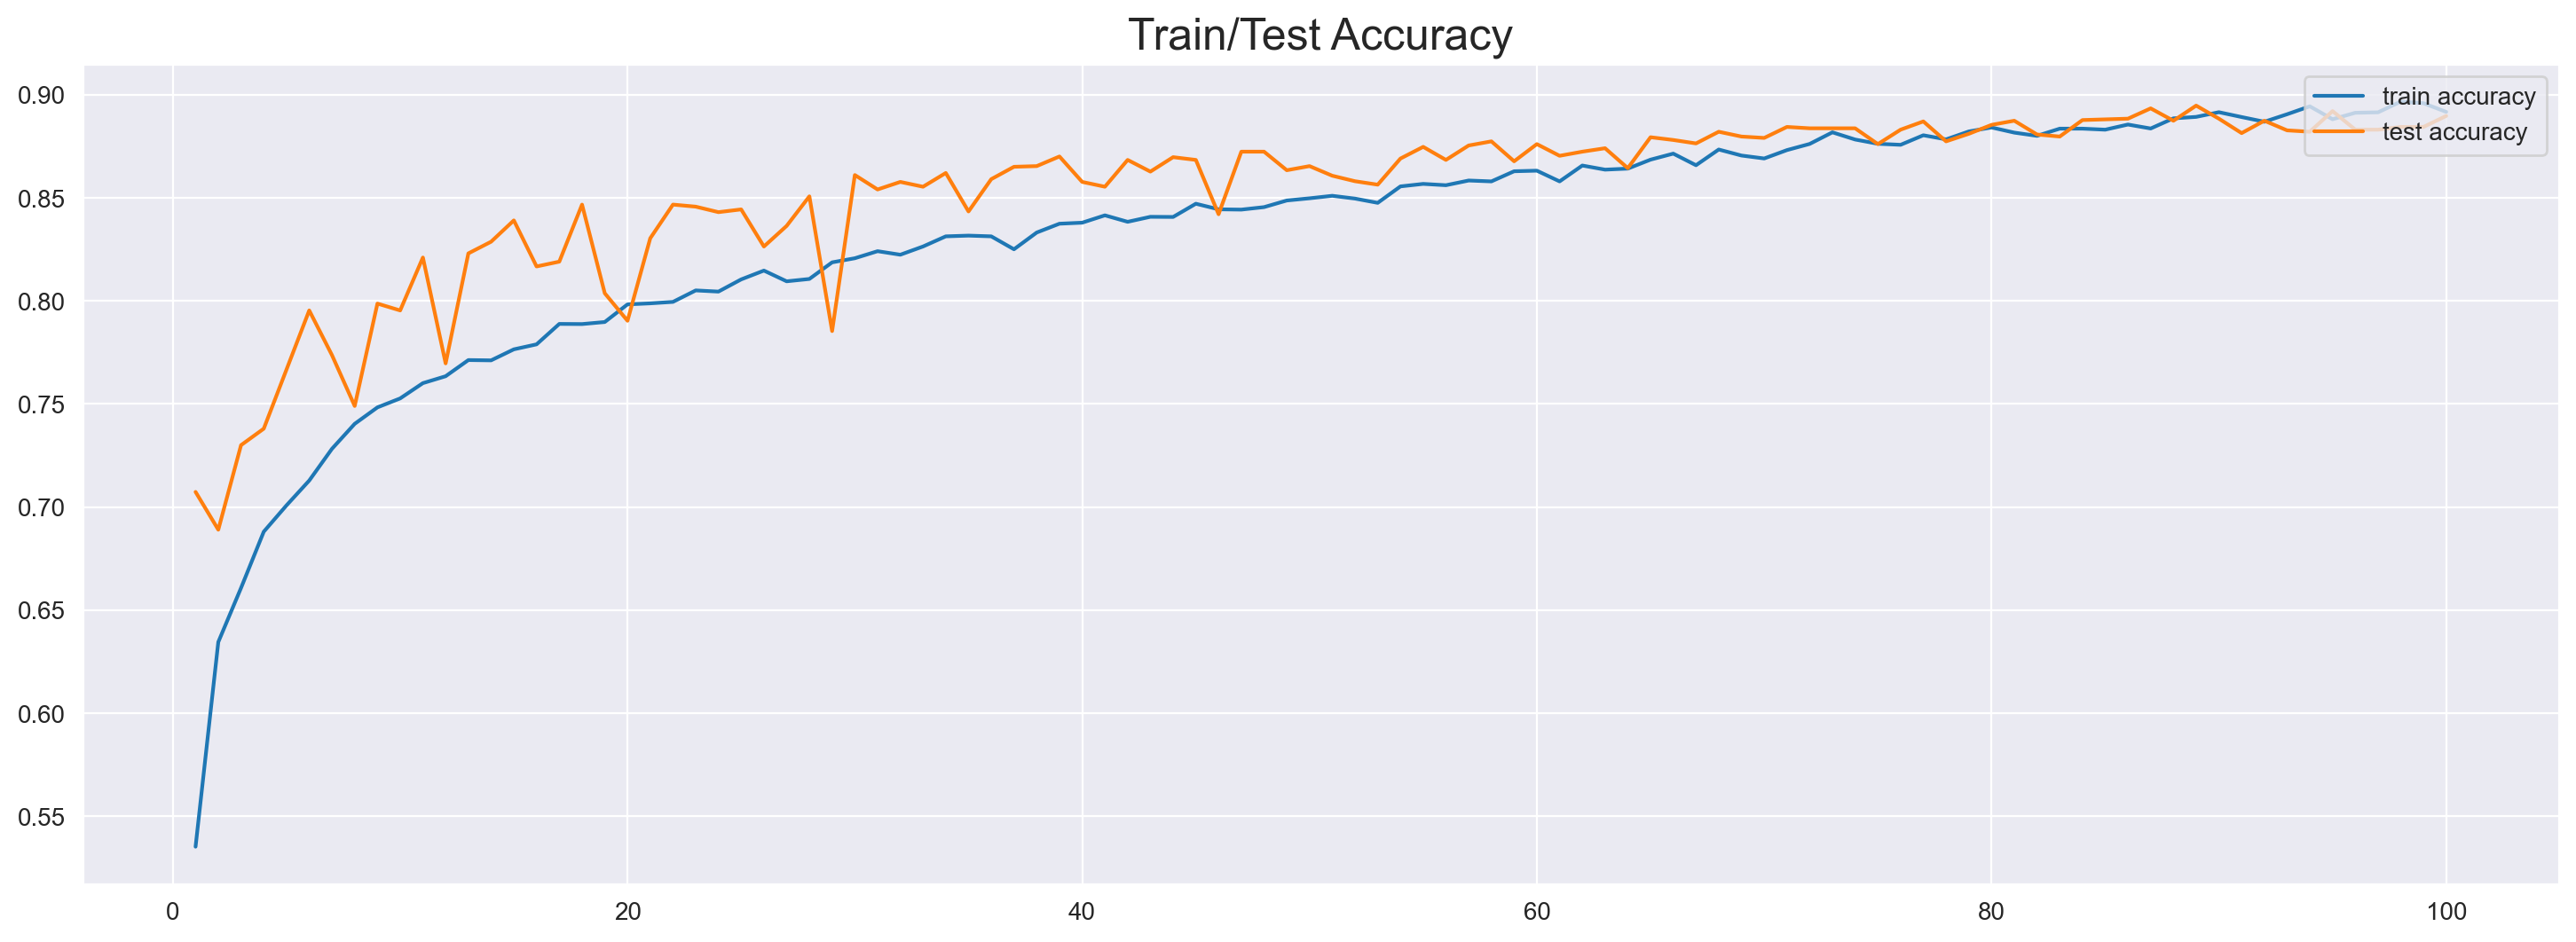

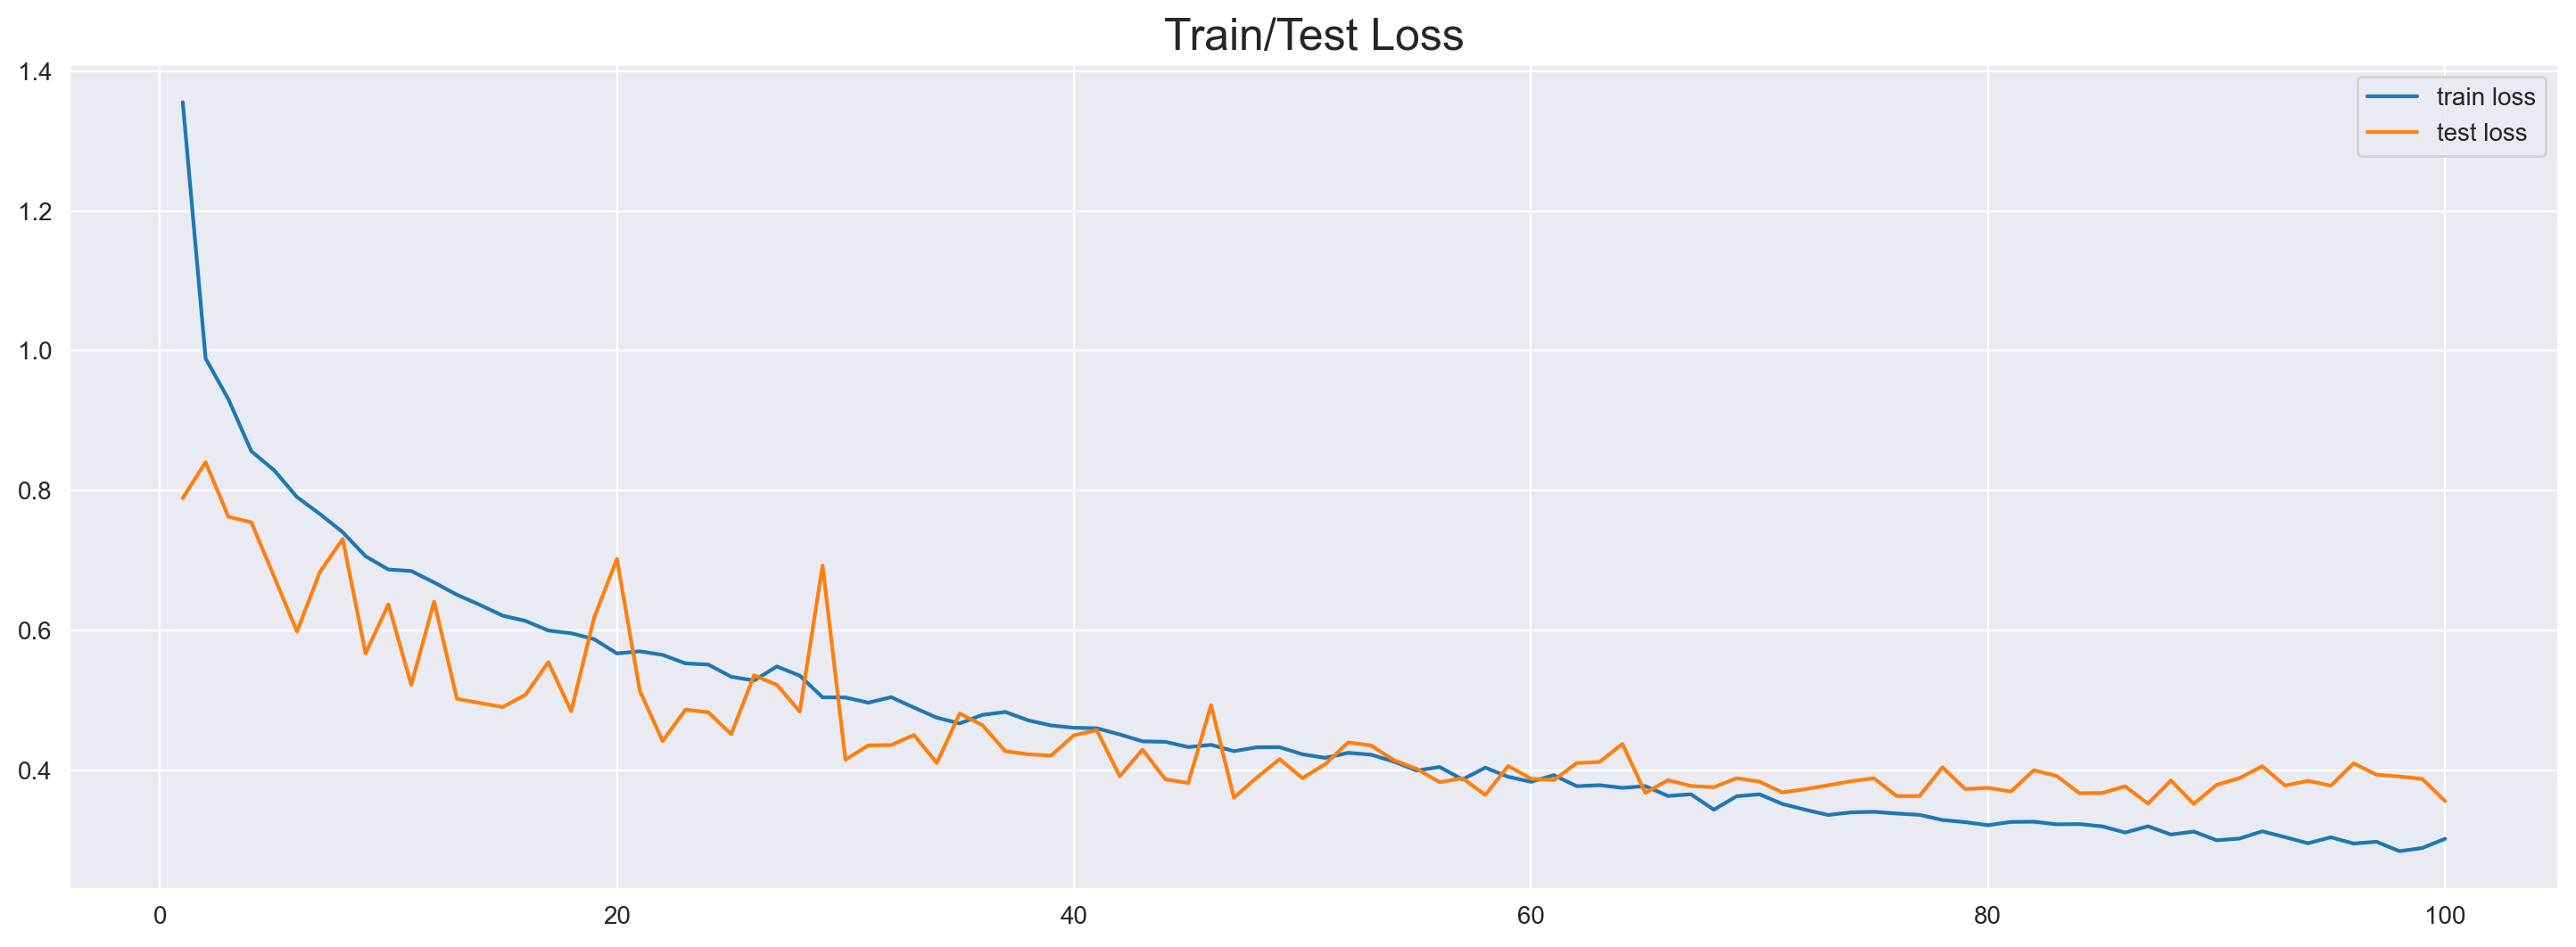

In [52]:
plt.figure(figsize=(18,6))
plt.plot(range(1,EPOCHS+1), train_accs, label='train accuracy')
plt.plot(range(1,EPOCHS+1), test_accs, label="test accuracy")
plt.legend(loc='upper right')
plt.title("Train/Test Accuracy", fontsize=18)
plt.show()

plt.figure(figsize=(18,6))
plt.plot(range(1,EPOCHS+1), train_losses, label='train loss')
plt.plot(range(1,EPOCHS+1), test_losses, label="test loss")
plt.legend(loc='upper right')
plt.title("Train/Test Loss", fontsize=18)
plt.show()

Save model

In [53]:
torch.save(model.state_dict(), "models/basic_CNN.pt")

Load model

In [30]:
model = CNN(num_classes=6)
model.load_state_dict(torch.load("models/basic_CNN.pt"))
model.eval()

CNN(
  (convolutional_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(128, eps=1e-05, mo

### Make prediction on the test set

In [23]:
len(test_data)
#length os the whole test set is too big, that's why I used just one batch for prediction

3000

Use BATCH_SIZE=20 to make prediction on the first 64 images.

In [41]:
test_set = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [49]:
X_test, labels = next(iter(test_set))
#as we have logits after the last layer of model, we have to use softmax activation function to get the probabilities
softmax = nn.Softmax(dim=1)
output = model(X_test)
y_probs = softmax(output)
y_probs = y_probs.detach().numpy()
y_pred = y_probs.argmax(axis=1)

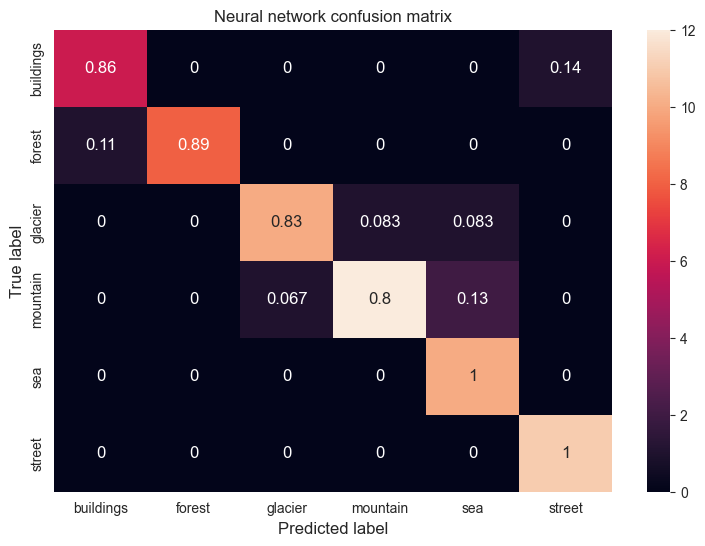

In [50]:
conf = confusion_matrix(labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=train_dataset.classes,
            xticklabels=train_dataset.classes,
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

In [51]:
print(classification_report(labels, y_pred, target_names=train_dataset.classes))

              precision    recall  f1-score   support

   buildings       0.86      0.86      0.86         7
      forest       1.00      0.89      0.94         9
     glacier       0.91      0.83      0.87        12
    mountain       0.92      0.80      0.86        15
         sea       0.77      1.00      0.87        10
      street       0.92      1.00      0.96        11

    accuracy                           0.89        64
   macro avg       0.90      0.90      0.89        64
weighted avg       0.90      0.89      0.89        64



### Roc-AUC curves

In [52]:
def calculate_auc_scores(y_test, y_prob, classes):
    auc_scores=[]
    for i in range(len(classes)):
        #prepare y_true as 1 if we have that class and 0 if not that class (other classes) - binarization
        y_true = [1 if y == i else 0 for y in y_test]
        auc_scores.append(roc_auc_score(y_true, y_prob[:,i]))

    return auc_scores

In [53]:
def plot_roc_curves_ovr(X_test, y_test, y_prob, classes, auc_scores):

    plt.figure(figsize=(9,5));

    colors=['b', 'g', 'r', 'c', 'm', 'y']

    for i in range(len(classes)):
        #prepare y_true as 1 if we have that class and 0 if not that class (other classes) - binarization
        y_true = [1 if y == i else 0 for y in y_test]
        fpr, tpr, _ = roc_curve(y_true, y_prob[:, i])

        sns.lineplot(x = fpr, y = tpr, label = classes[i]+ "  auc-score=%.4f" % auc_scores[i], color=colors[i]);
        plt.xlim(-0.05, 1.05);
        plt.ylim(-0.05, 1.05);
        plt.xlabel("False Positive Rate");
        plt.ylabel("True Positive Rate");

    sns.lineplot(x = [0, 1], y = [0, 1], color = 'blue', linestyle='--');

    plt.legend(loc="best");
    plt.title("Roc-curves for each class");
    plt.show();

In [54]:
def plot_precision_recall_curves(y_test, y_prob, classes):

    precision = dict()
    recall = dict()

    colors=['b', 'g', 'r', 'c', 'm', 'y']

    plt.figure(figsize=(9,5));
    for i in range(len(classes)):
        #prepare y_true as 1 if we have that class and 0 if not that class (other classes) - binarization of y_test
        y_true = np.array([1 if y == i else 0 for y in y_test])
        precision[i], recall[i], _ = precision_recall_curve(y_true,
                                                        y_prob[:, i])

        plt.plot(recall[i], precision[i], label=classes[i]+" auc-PR=%.4f" % auc(recall[i], precision[i]), color=colors[i]);

        baseline = len(y_true[y_true==1]) / len(y_true) # the fraction of that class in the whole dataset, the model which always predict that class will have such precision
        plt.plot([0, 1], [baseline, baseline], linestyle='--', color=colors[i], label=f'Baseline for {classes[i]}')

    plt.xlabel("recall");
    plt.ylabel("precision");
    plt.legend(loc="best");
    plt.title("Precision vs. recall curve for each class");
    plt.show();

In [55]:
auc_scores = calculate_auc_scores(labels, y_probs, train_dataset.classes)

### Roc-curves for each class

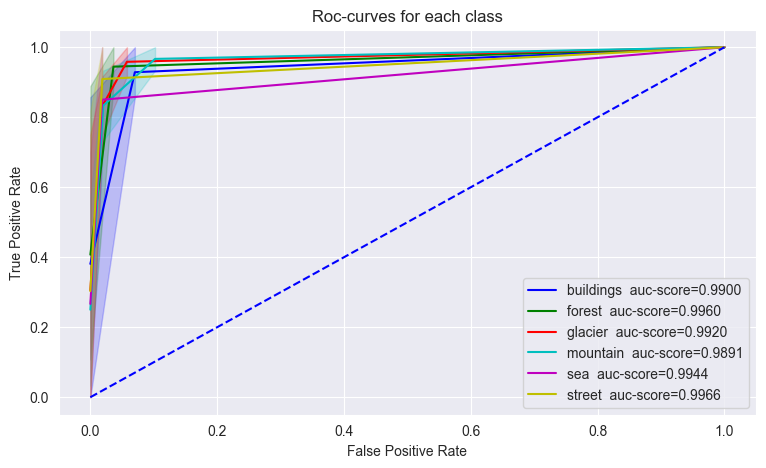

In [56]:
plot_roc_curves_ovr(X_test, labels, y_probs, train_dataset.classes, auc_scores)

### Precision-recall curves for each class

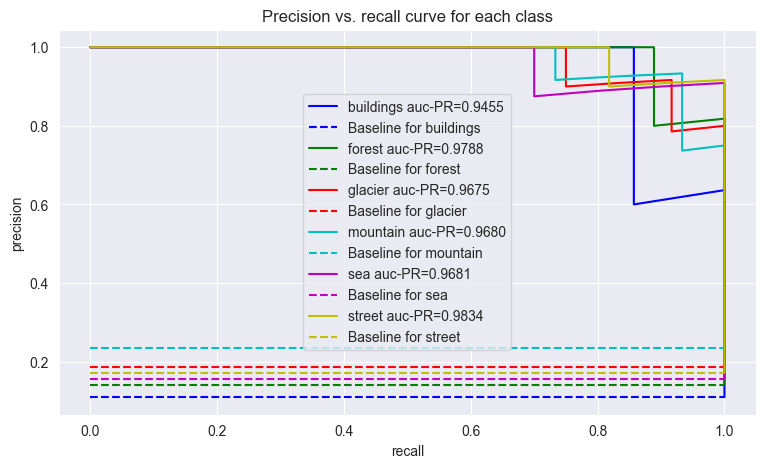

In [57]:
plot_precision_recall_curves(labels, y_probs, train_dataset.classes)

### Visualization of predictions

In [58]:
def show_predictions(X_test, labels, y_pred):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    plt.figure(figsize=(20, 10))
    #choose random 20 pictures
    idx = np.random.randint(0, len(X_test), 20)
    for i, index in enumerate(idx):
        ax = plt.subplot(4, 5, i + 1)
        img=X_test[index].numpy().transpose((1,2,0));
        #inverse transformation from standartization
        img=img*std+mean;
        plt.imshow(img)
        plt.title(f"Label: {train_dataset.classes[labels[index]]} \n Predicted: {train_dataset.classes[y_pred[index]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

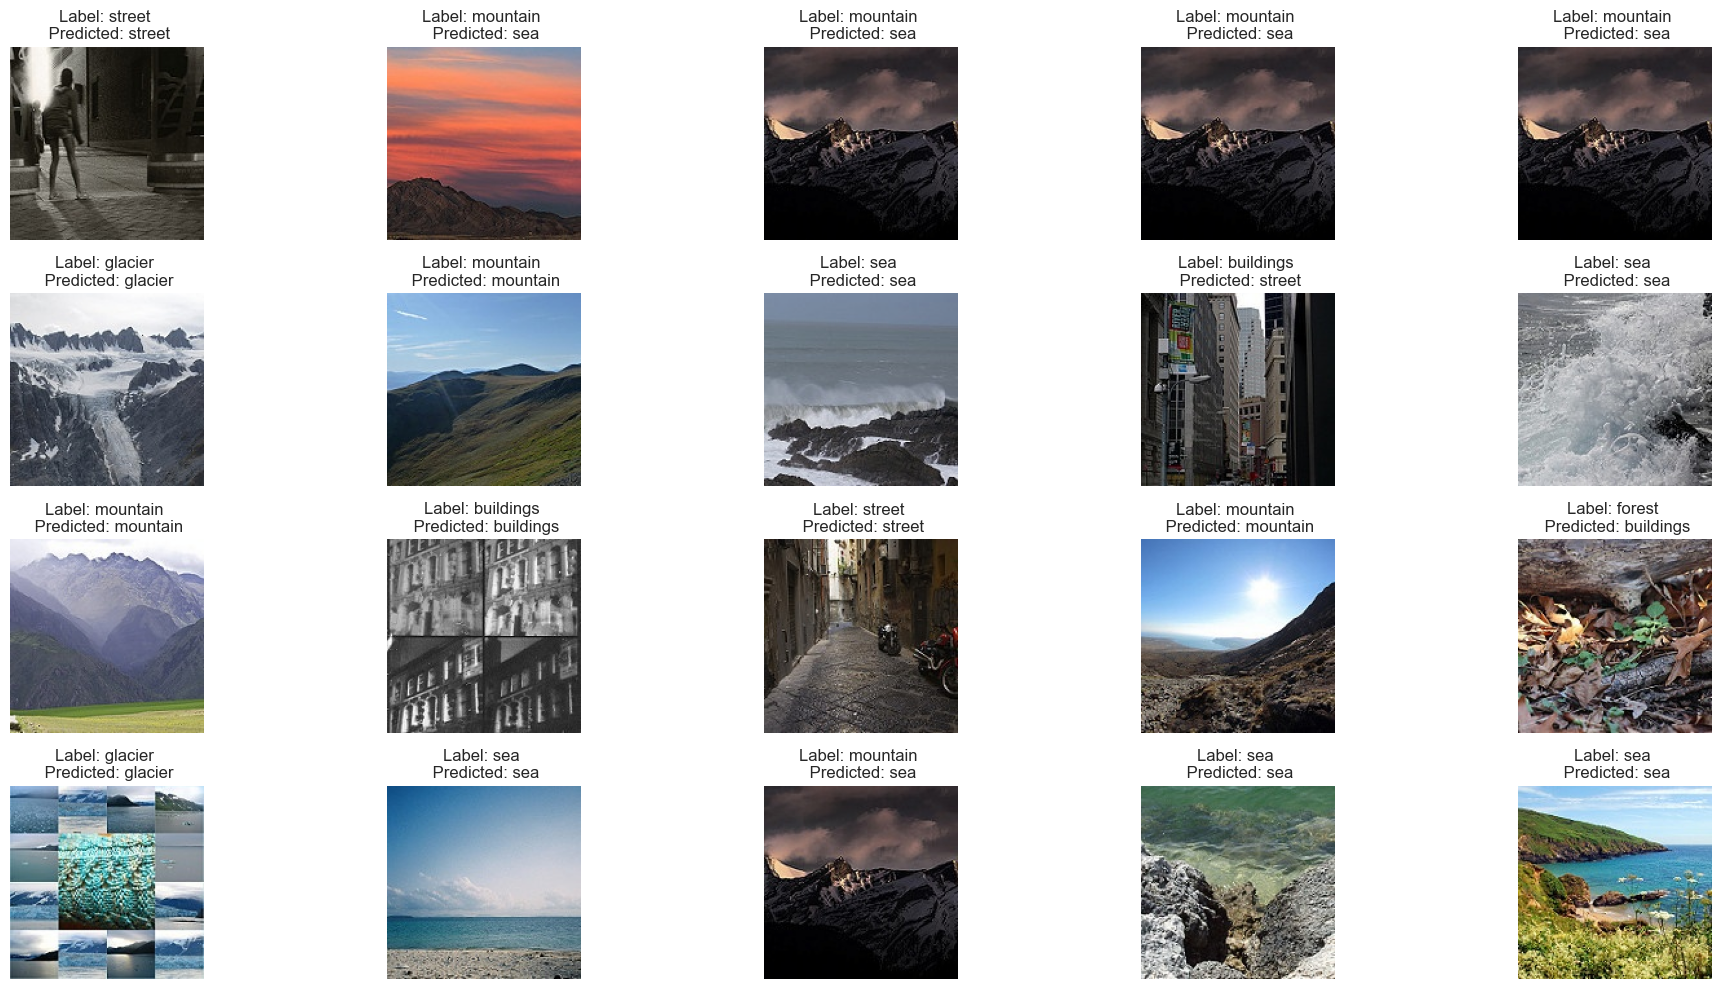

In [59]:
show_predictions(X_test, labels, y_pred)

# Fine-tuned CNN

I will use pretrained model VGG19.

In [62]:
vgg19_model = models.vgg19(pretrained=True)

In [63]:
# freeze parameters in all layers
for param in vgg19_model.parameters():
    param.requires_grad = False

In [64]:
vgg19_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [65]:
# change output features of the last classification layer to 6 classes
vgg19_model.classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=4096, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(in_features=4096, out_features=6, bias=True)
)

To use VGG19 I will change transformation of images: resize images from 150X150 to 224X224, as it is needed for the architecture of VGG19.

In [66]:
#transformation with augmentation
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomRotation((0,40)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomResizedCrop((224, 224), scale=(0.2, 1), ratio=(1, 1)),
    transforms.ToTensor(), #rescale image from (0-255) to (0,1)
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #normalization from ImageNet
])


test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [67]:
train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)

In [68]:
BATCH_SIZE = 64

In [69]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [104]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg19_model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.9, patience=5, verbose=True)

In [105]:
EPOCHS = 5
train_losses, test_losses, train_accs, test_accs = train_CNN(vgg19_model, loss, optimizer, train_dataloader, test_dataloader, EPOCHS)

Epoch 1/5  Train Loss: 0.7176  Train Acc:  0.7895 Val Loss: 0.2964 Val Acc:  0.9003 Duration: 0:48:36.822921
Epoch 2/5  Train Loss: 0.4984  Train Acc:  0.8264 Val Loss: 0.2837 Val Acc:  0.9063 Duration: 0:48:50.443026
Epoch 3/5  Train Loss: 0.4938  Train Acc:  0.8278 Val Loss: 0.3168 Val Acc:  0.8933 Duration: 0:47:14.957003
Epoch 4/5  Train Loss: 0.4924  Train Acc:  0.8337 Val Loss: 0.2975 Val Acc:  0.9063 Duration: 0:46:59.369688
Epoch 5/5  Train Loss: 0.4784  Train Acc:  0.8442 Val Loss: 0.2811 Val Acc:  0.9123 Duration: 0:46:52.925205


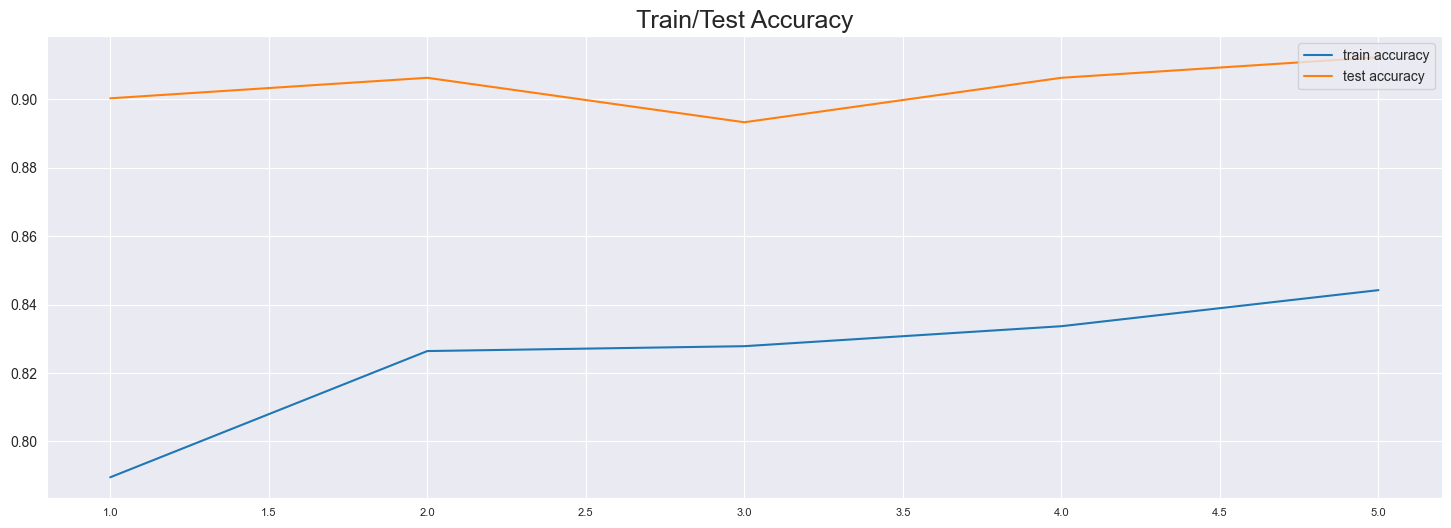

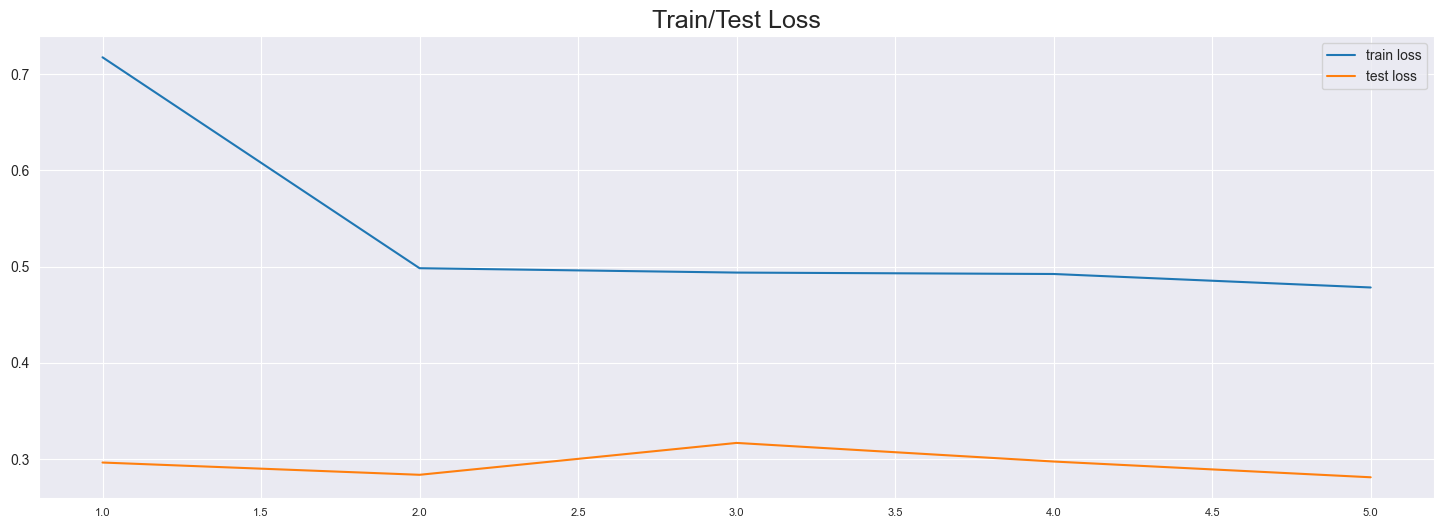

In [106]:
plt.figure(figsize=(18,6))
plt.plot(range(1,EPOCHS+1), train_accs, label='train accuracy')
plt.plot(range(1,EPOCHS+1), test_accs, label="test accuracy")
plt.legend(loc='upper right')
plt.title("Train/Test Accuracy", fontsize=18)
plt.show()

plt.figure(figsize=(18,6))
plt.plot(range(1,EPOCHS+1), train_losses, label='train loss')
plt.plot(range(1,EPOCHS+1), test_losses, label="test loss")
plt.legend(loc='upper right')
plt.title("Train/Test Loss", fontsize=18)
plt.show()

Save model

In [108]:
torch.save(vgg19_model.state_dict(), "models/vgg19_model.pt")

Load model

In [70]:
vgg19_model.load_state_dict(torch.load("models/vgg19_model.pt"))
vgg19_model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

### Make prediction on the same test set (that was used for my NN model)

In [71]:
X_test, labels = next(iter(test_set))
#as we have logits after the last layer of model, we have to use softmax activation function to get the probabilities
softmax = nn.Softmax(dim=1)
output = vgg19_model(X_test)
y_probs = softmax(output)
y_probs = y_probs.detach().numpy()
y_pred = y_probs.argmax(axis=1)

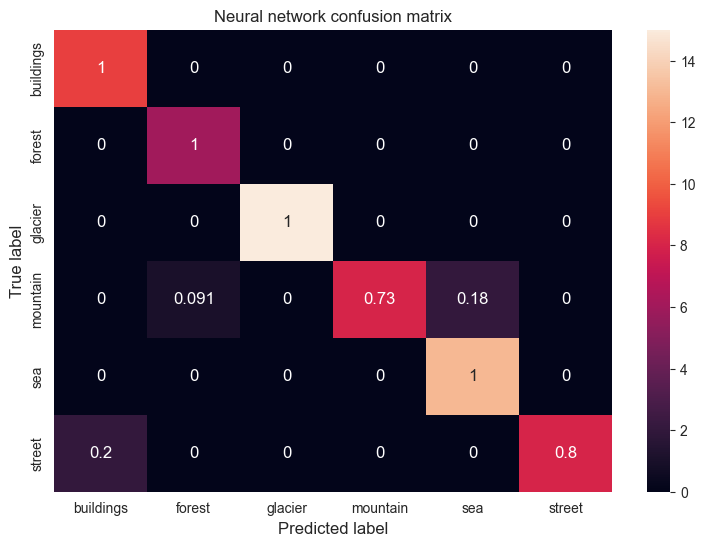

In [73]:
conf = confusion_matrix(labels, y_pred)
plt.figure(figsize=(9, 6));
sns.heatmap(conf,
            annot=conf / conf.astype(np.float).sum(axis=1, keepdims=True),  #normalized by true class sizes
            annot_kws={"size": 12},
            yticklabels=train_dataset.classes,
            xticklabels=train_dataset.classes,
            )
plt.title('Neural network confusion matrix', fontsize=12);
plt.xlabel('Predicted label', fontsize=12);
plt.ylabel('True label', fontsize=12);

In [74]:
print(classification_report(labels, y_pred, target_names=train_dataset.classes))

              precision    recall  f1-score   support

   buildings       0.82      1.00      0.90         9
      forest       0.86      1.00      0.92         6
     glacier       1.00      1.00      1.00        15
    mountain       1.00      0.73      0.84        11
         sea       0.87      1.00      0.93        13
      street       1.00      0.80      0.89        10

    accuracy                           0.92        64
   macro avg       0.92      0.92      0.91        64
weighted avg       0.93      0.92      0.92        64



### Roc-curves for each class

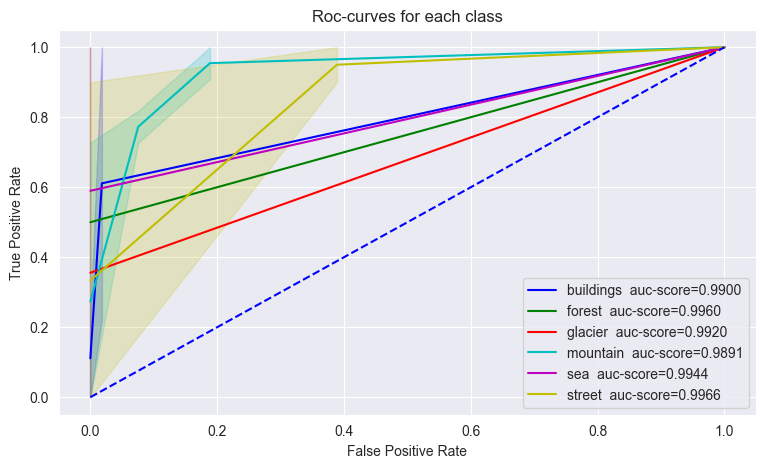

In [75]:
plot_roc_curves_ovr(X_test, labels, y_probs, train_dataset.classes, auc_scores)

### Precision-recall curves for each class

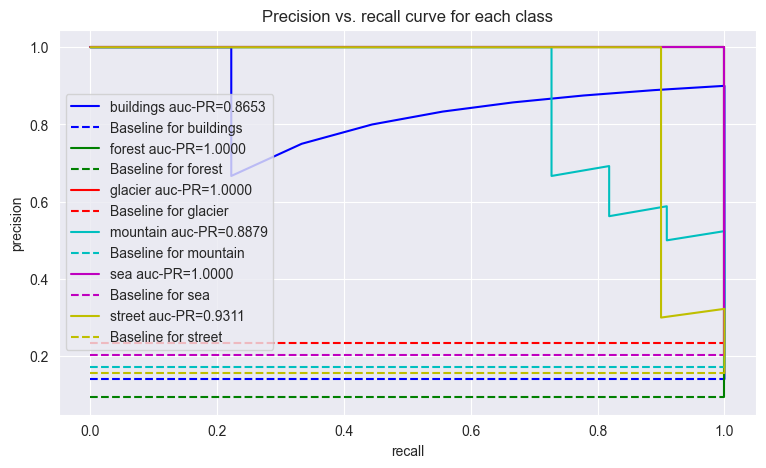

In [76]:
plot_precision_recall_curves(labels, y_probs, train_dataset.classes)

### Visualization of predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

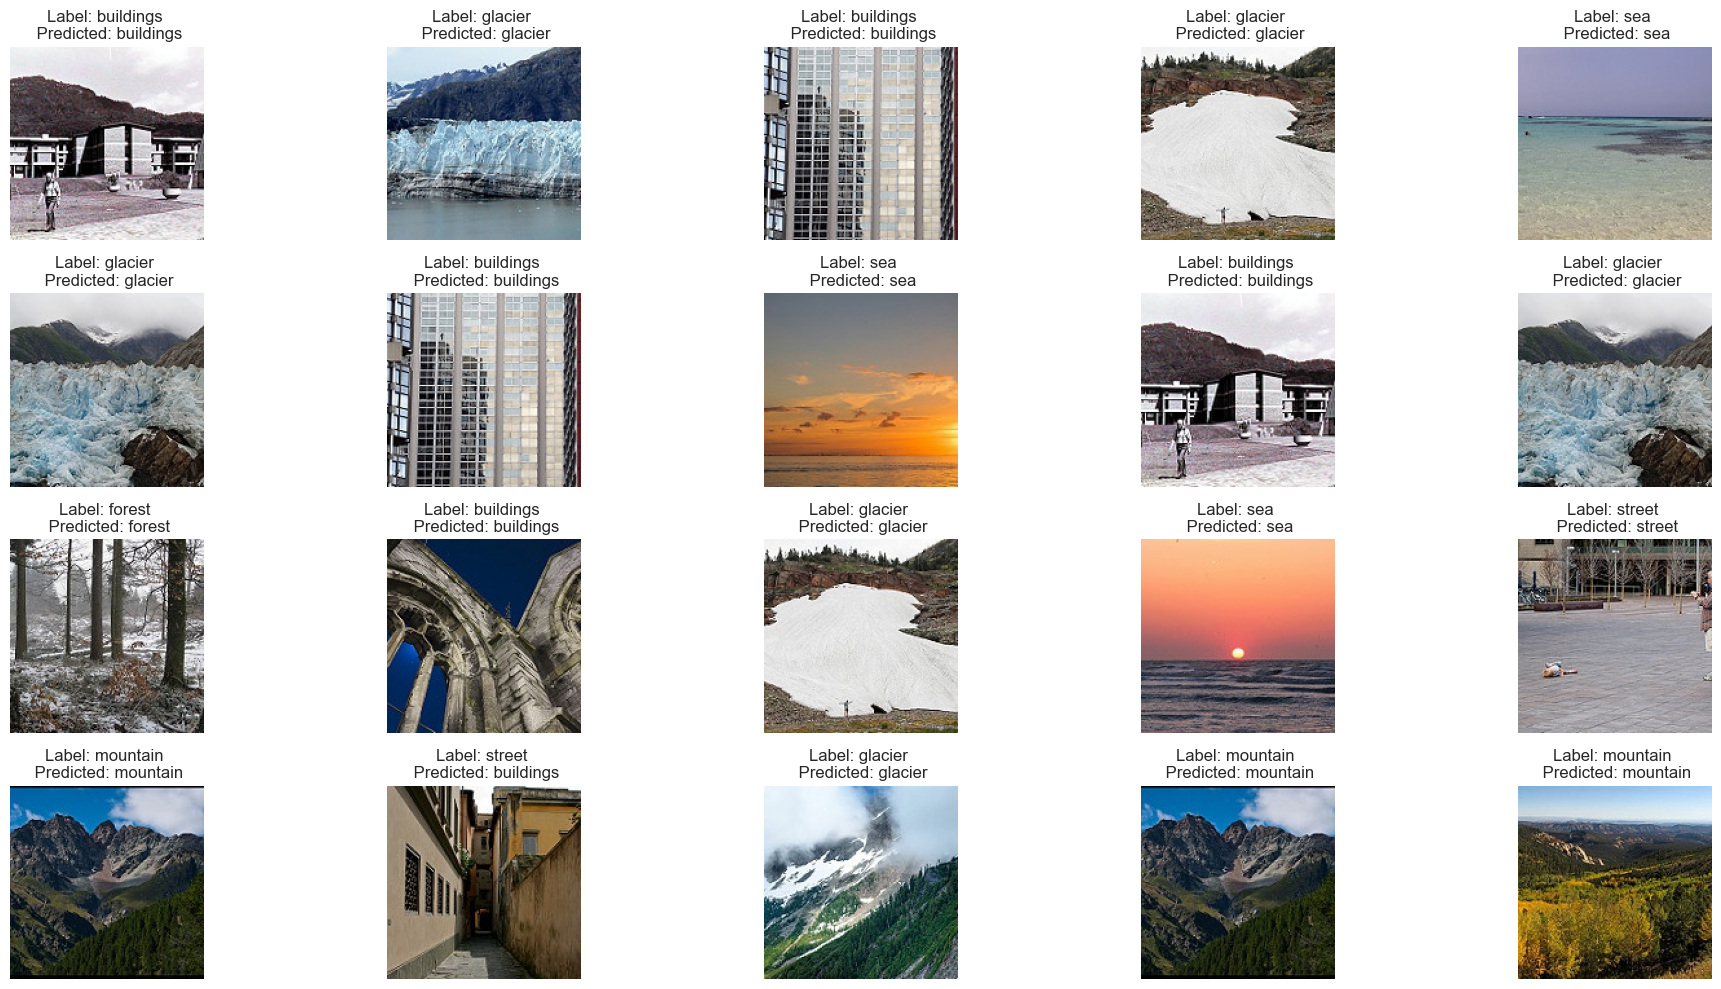

In [77]:
show_predictions(X_test, labels, y_pred)